# Load the libraries

In [1]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
library(grid)
library(gridExtra)
source("helper_functions.R")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“package ‘sva’ was built under R version 3.6.1”Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Warning message:
“package ‘genefilter’ was built under R version 3.6.1”Loading required package: BiocParallel
Warning message:
“package ‘BiocParallel’ was built under R version 3.6.1”Warning message:
“package ‘ggExtra’ was built under R version 3.6.1”Warning message:
“package ‘nnls’ was built under R version 3.6.1”

# Load the necessary input

In [2]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V6";

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [3]:
## start with pdcs since there's one person without any
pdc_covs <- fread("v6.expr/v6.full.pDC.blind.covs.txt");
colnames(pdc_covs) <- sapply(colnames(pdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- pdc_covs$V1;
pdc_covs <- as.matrix(pdc_covs[,-1]);

cm_covs <- as.matrix(fread("v6.expr/v6.full.cM.blind.covs.txt")[,-1]);
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cm_covs <- cm_covs[match(pdc_covs[,"sample"], cm_covs[,"sample"]),];

th_covs <- as.matrix(fread("v6.expr/v6.full.Th.blind.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
th_covs <- th_covs[match(pdc_covs[,"sample"], th_covs[,"sample"]),];

tc_covs <- as.matrix(fread("v6.expr/v6.full.Tc.blind.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
tc_covs <- tc_covs[match(pdc_covs[,"sample"], tc_covs[,"sample"]),];

ncm_covs <- as.matrix(fread("v6.expr/v6.full.ncM.blind.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
ncm_covs <- ncm_covs[match(pdc_covs[,"sample"], ncm_covs[,"sample"]),];

b_covs <- as.matrix(fread("v6.expr/v6.full.B.blind.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
b_covs <- b_covs[match(pdc_covs[,"sample"], b_covs[,"sample"]),];

nk_covs <- as.matrix(fread("v6.expr/v6.full.NK.blind.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
nk_covs <- nk_covs[match(pdc_covs[,"sample"], nk_covs[,"sample"]),];

cdc_covs <- as.matrix(fread("v6.expr/v6.full.cDC.blind.covs.txt")[,-1]);
colnames(cdc_covs) <- sapply(colnames(cdc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
cdc_covs <- cdc_covs[match(pdc_covs[,"sample"], cdc_covs[,"sample"]),];

pbmc_covs <- as.matrix(fread("v6.expr/v6.full.PBMC.blind.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
pbmc_covs <- pbmc_covs[match(pdc_covs[,"sample"], pbmc_covs[,"sample"]),];

# pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.covs.txt")[,-1]);
# colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(cdc_covs) <- rownames(pdc_covs)<- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [4]:
pdc_expr <- fread("v6.expr/v6.full.pDC.blind.expr.txt");
colnames(pdc_expr) <- sapply(colnames(pdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- pdc_expr$V1;
pdc_expr <- as.matrix(pdc_expr[,-1]);

th_expr <- as.matrix(fread("v6.expr/v6.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_expr <- th_expr[,colnames(pdc_expr)];

tc_expr <- as.matrix(fread("v6.expr/v6.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_expr <- tc_expr[,colnames(pdc_expr)];

ncm_expr <- as.matrix(fread("v6.expr/v6.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_expr <- ncm_expr[,colnames(pdc_expr)];

b_expr <- as.matrix(fread("v6.expr/v6.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_expr <- b_expr[,colnames(pdc_expr)];

nk_expr <- as.matrix(fread("v6.expr/v6.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_expr <- nk_expr[,colnames(pdc_expr)];

cdc_expr <- as.matrix(fread("v6.expr/v6.full.cDC.blind.expr.txt")[,-1]);
colnames(cdc_expr) <- sapply(colnames(cdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_expr <- cdc_expr[,colnames(pdc_expr)];

cm_expr <- as.matrix(fread("v6.expr/v6.full.cM.blind.expr.txt")[,-1]);
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_expr <- cm_expr[,colnames(pdc_expr)];

pbmc_expr <- as.matrix(fread("v6.expr/v6.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_expr <- pbmc_expr[,colnames(pdc_expr)];

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(cdc_expr) <-rownames(pdc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(cdc_expr)==0),
                     which(rowSums(pdc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
cdc_expr <- cdc_expr[-any_zeros,];
pdc_expr <- pdc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v6.expr/v6.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.expr/v6.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.expr/v6.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames

## Load the processed counts data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [5]:
pdc_counts <- fread("v6.expr/v6.full.pDC.blind.counts.txt");
colnames(pdc_counts) <- sapply(colnames(pdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
counts_gene_names <- pdc_counts$V1_NA;
pdc_counts <- as.matrix(pdc_counts[,-1]);
pdc_counts <- pdc_counts[match(expr_gene_names, counts_gene_names),]

pdc_expr_raw <- as.matrix(fread("v6.expr/v6.full.pDC.blind.expr.txt"))[,-1];
th_expr_raw <- as.matrix(fread("v6.expr/v6.full.Th.blind.expr.txt"))[,-1];
pdc_indices <- match(colnames(pdc_expr_raw), colnames(th_expr_raw));

th_counts <- as.matrix(fread("v6.expr/v6.full.Th.blind.counts.txt")[,-1]);
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_counts <- th_counts[match(expr_gene_names, counts_gene_names),]
th_counts <- th_counts[,pdc_indices];

tc_counts <- as.matrix(fread("v6.expr/v6.full.Tc.blind.counts.txt")[,-1]);
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_counts <- tc_counts[match(expr_gene_names, counts_gene_names),]
tc_counts <- tc_counts[,pdc_indices];

ncm_counts <- as.matrix(fread("v6.expr/v6.full.ncM.blind.counts.txt")[,-1]);
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_counts <- ncm_counts[match(expr_gene_names, counts_gene_names),]
ncm_counts <- ncm_counts[,pdc_indices];

b_counts <- as.matrix(fread("v6.expr/v6.full.B.blind.counts.txt")[,-1]);
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_counts <- b_counts[match(expr_gene_names, counts_gene_names),]
b_counts <- b_counts[,pdc_indices];

nk_counts <- as.matrix(fread("v6.expr/v6.full.NK.blind.counts.txt")[,-1]);
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_counts <- nk_counts[match(expr_gene_names, counts_gene_names),]
nk_counts <- nk_counts[,pdc_indices];

cdc_counts <- as.matrix(fread("v6.expr/v6.full.cDC.blind.counts.txt")[,-1]);
colnames(cdc_counts) <- sapply(colnames(cdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_counts <- cdc_counts[match(expr_gene_names, counts_gene_names),]
cdc_counts <- cdc_counts[,pdc_indices];

cm_counts <- as.matrix(fread("v6.expr/v6.full.cM.blind.counts.txt")[,-1]);
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_counts <- cm_counts[match(expr_gene_names, counts_gene_names),]
cm_counts <- cm_counts[,pdc_indices];

pbmc_counts <- as.matrix(fread("v6.expr/v6.full.PBMC.blind.counts.txt")[,-1]);
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_counts <- pbmc_counts[match(expr_gene_names, counts_gene_names),]
pbmc_counts <- pbmc_counts[,pdc_indices];

rownames(pbmc_counts) <- rownames(cm_counts) <- rownames(th_counts) <- rownames(tc_counts) <- rownames(ncm_counts) <- rownames(b_counts) <- rownames(nk_counts) <-rownames(cdc_counts) <-rownames(pdc_counts) <- expr_gene_names;
colnames(pbmc_counts) <- colnames(cm_counts) <- colnames(th_counts) <- colnames(tc_counts) <- colnames(ncm_counts) <- colnames(b_counts) <- colnames(nk_counts) <-colnames(cdc_counts) <-colnames(pdc_counts) <- colnames(pbmc_expr)

# ## do a quick filter for all zeros
# any_zeros = unique(c(which(rowSums(pbmc_counts) ==0),
#                      which(rowSums(cm_counts)==0),
#                      which(rowSums(ncm_counts)==0),
#                      which(rowSums(th_counts)==0),
#                      which(rowSums(tc_counts)==0),
#                      which(rowSums(b_counts)==0),
#                      which(rowSums(nk_counts)==0),
#                      which(rowSums(cdc_counts)==0),
#                      which(rowSums(pdc_counts)==0)))
# pbmc_counts <- pbmc_counts[-any_zeros,];
# cm_counts <- cm_counts[-any_zeros,];
# ncm_counts <- ncm_counts[-any_zeros,];
# th_counts <- th_counts[-any_zeros,];
# tc_counts <- tc_counts[-any_zeros,];
# b_counts <- b_counts[-any_zeros,];
# nk_counts <- nk_counts[-any_zeros,];
# cdc_counts <- cdc_counts[-any_zeros,];
# pdc_counts <- pdc_counts[-any_zeros,];
# ##counts_gene_names <- counts_gene_names[-any_zeros];


Warning message in fread("v6.expr/v6.full.pDC.blind.counts.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.expr/v6.full.pDC.blind.expr.txt"):
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.expr/v6.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setna

## let's normalize counts in two ways: 1. by total number of counts per donor and 2. by number of counts per cell type per donor

In [6]:
pbmc_total <- apply(pbmc_counts, 2, sum)

pbmc_colSums <- colSums(pbmc_counts);
pbmc_expr <- t(sapply(1:nrow(pbmc_counts), function(x) {pbmc_counts[x,]/pbmc_colSums}))

cm_colSums <- colSums(cm_counts);
cm_expr_pbmc_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/pbmc_colSums}))
cm_expr_ct_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/cm_colSums}))

ncm_colSums <- colSums(ncm_counts);
ncm_expr_pbmc_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/pbmc_colSums}))
ncm_expr_ct_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/ncm_colSums}))

th_colSums <- colSums(th_counts);
th_expr_pbmc_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/pbmc_colSums}))
th_expr_ct_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/th_colSums}))

tc_colSums <- colSums(tc_counts);
tc_expr_pbmc_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/pbmc_colSums}))
tc_expr_ct_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/tc_colSums}))

b_colSums <- colSums(b_counts)
b_expr_pbmc_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/pbmc_colSums}))
b_expr_ct_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/b_colSums}))

nk_colSums <- colSums(nk_counts);
nk_expr_pbmc_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/pbmc_colSums}))
nk_expr_ct_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/nk_colSums}))

cdc_colSums <- colSums(cdc_counts);
cdc_expr_pbmc_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/pbmc_colSums}))
cdc_expr_ct_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/cdc_colSums}))

pdc_colSums <- colSums(pdc_counts);
pdc_expr_pbmc_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pbmc_colSums}))
pdc_expr_ct_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pdc_colSums}))

rownames(pbmc_expr) <- rownames(cm_expr_pbmc_counts) <- rownames(ncm_expr_pbmc_counts) <- rownames(th_expr_pbmc_counts) <- rownames(tc_expr_pbmc_counts) <- rownames(b_expr_pbmc_counts) <- rownames(nk_expr_pbmc_counts) <- rownames(cdc_expr_pbmc_counts) <- rownames(pdc_expr_pbmc_counts) <- expr_gene_names

rownames(cm_expr_ct_counts) <- rownames(ncm_expr_ct_counts) <- rownames(th_expr_ct_counts) <- rownames(tc_expr_ct_counts) <- rownames(b_expr_ct_counts) <- rownames(nk_expr_ct_counts) <- rownames(cdc_expr_ct_counts) <- rownames(pdc_expr_ct_counts) <- expr_gene_names

[,1]        [,2]         [,3]        [,4]         [,5]        
[1,] 1.38524e-08 5.474444e-09 4.44157e-10 8.822345e-09 3.876742e-09
     [,6]         [,7]         [,8]         [,9]        
[1,] 2.170993e-09 6.231111e-10 6.087662e-11 9.267036e-12

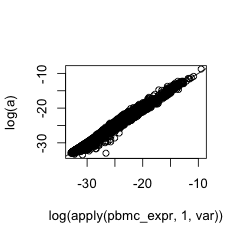

In [7]:
t(c(mean(apply(pbmc_expr,1,var),na.rm=T),mean(apply(cm_expr_pbmc_counts,1,var),na.rm=T),mean(apply(ncm_expr_pbmc_counts,1,var),na.rm=T),mean(apply(th_expr_pbmc_counts,1,var),na.rm=T),mean(apply(tc_expr_pbmc_counts,1,var),na.rm=T),mean(apply(b_expr_pbmc_counts,1,var),na.rm=T),mean(apply(nk_expr_pbmc_counts,1,var),na.rm=T),mean(apply(cdc_expr_pbmc_counts,1,var),na.rm=T),mean(apply(pdc_expr_pbmc_counts,1,var),na.rm=T)))

a <- apply(cm_expr_pbmc_counts,1,var)+apply(ncm_expr_pbmc_counts,1,var)+apply(th_expr_pbmc_counts,1,var)+apply(tc_expr_pbmc_counts,1,var)+apply(b_expr_pbmc_counts,1,var)+apply(nk_expr_pbmc_counts,1,var)+apply(cdc_expr_pbmc_counts,1,var)+apply(pdc_expr_pbmc_counts,1,var)

plot(log(apply(pbmc_expr,1,var)), log(a));
abline(a=0,b=1)

In [8]:
t(c(var(pbmc_expr["CD14",]),var(cm_expr_pbmc_counts["CD14",]),var(ncm_expr_pbmc_counts["CD14",]),var(th_expr_pbmc_counts["CD14",]),var(tc_expr_pbmc_counts["CD14",]),var(b_expr_pbmc_counts["CD14",]),var(cdc_expr_pbmc_counts["CD14",]),var(pdc_expr_pbmc_counts["CD14",])))
sum(var(cm_expr_pbmc_counts["CD14",]), var(ncm_expr_pbmc_counts["CD14",]), var(th_expr_pbmc_counts["CD14",]), var(tc_expr_pbmc_counts["CD14",]), var(b_expr_pbmc_counts["CD14",]), var(cdc_expr_pbmc_counts["CD14",]), var(pdc_expr_pbmc_counts["CD14",]))

[,1]         [,2]         [,3]         [,4]         [,5]        
[1,] 8.732244e-09 8.566332e-09 1.027497e-11 5.211082e-12 1.956957e-12
     [,6]         [,7]         [,8]        
[1,] 1.327608e-12 1.872565e-12 3.229542e-14

[1] 8.587008e-09

## filter samples

In [9]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

### all samples

In [10]:
cm_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_samples_nodups];
th_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_samples_nodups];
tc_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_samples_nodups];
ncm_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_samples_nodups];
b_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_samples_nodups];
nk_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_samples_nodups];
cdc_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_samples_nodups];
pdc_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_expr_ct_counts <- cm_expr_ct_counts[,ucsf_samples_nodups];
th_expr_ct_counts <- th_expr_ct_counts[,ucsf_samples_nodups];
tc_expr_ct_counts <- tc_expr_ct_counts[,ucsf_samples_nodups];
ncm_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_samples_nodups];
b_expr_ct_counts <- b_expr_ct_counts[,ucsf_samples_nodups];
nk_expr_ct_counts <- nk_expr_ct_counts[,ucsf_samples_nodups];
cdc_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_samples_nodups];
pdc_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
cdc_covs <- cdc_covs[ucsf_samples_nodups,];
pdc_covs <- pdc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

### SLE

In [11]:
sle_indices <- setdiff((1:ncol(cm_expr_pbmc_counts)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

### UCSF healthy

In [12]:
ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")


cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

### broad healthy

In [13]:
broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

In [14]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))


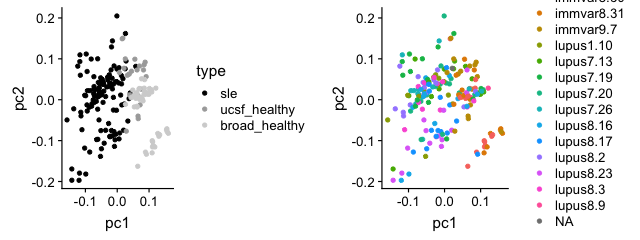

In [15]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

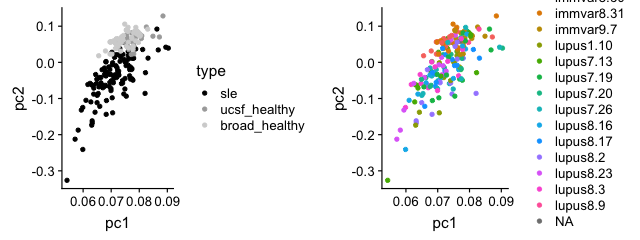

In [16]:
pbmc_expr_prcomp <- prcomp(pbmc_expr)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]


options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

In [17]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(pbmc_deseq_sig_genes,rownames(pbmc_expr_std))),])

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

## Load the differentially expression results

In [18]:
pbmc_deseq <- fread("v6.deseq/v6..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v6.deseq/v6..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v6.deseq/v6..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v6.deseq/v6..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v6.deseq/v6..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v6.deseq/v6..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v6.deseq/v6..NK.deseq.txt"))
cdc_deseq <- as.data.frame(fread("v6.deseq/v6..cDC.deseq.txt"))
pdc_deseq <- as.data.frame(fread("v6.deseq/v6..pDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v6.deseq/v6..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v6.deseq/v6..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v6.deseq/v6..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v6.deseq/v6..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v6.deseq/v6..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v6.deseq/v6..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v6.deseq/v6..NK.deseq.sig.txt",header=F))$V1
cdc_deseq_sig <- as.data.frame(fread("v6.deseq/v6..cDC.deseq.sig.txt",header=F))$V1
pdc_deseq_sig <- as.data.frame(fread("v6.deseq/v6..pDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, cdc_deseq_sig, pdc_deseq_sig));

Warning message in fread("v6.deseq/v6..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.deseq/v6..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v6.deseq/v6..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not 

In [19]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
cdc_deseq_sig_genes <- cdc_deseq$V1[intersect(which(cdc_deseq$baseMean > 25), intersect(which(abs(cdc_deseq$log2FoldChange)>1),which(cdc_deseq$qval < 0.01)))]
pdc_deseq_sig_genes <- pdc_deseq$V1[intersect(which(pdc_deseq$baseMean > 25), intersect(which(abs(pdc_deseq$log2FoldChange)>1),which(pdc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, cdc_deseq_sig_genes, pdc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 185

[1] 143

[1] 143

## Load the joined table and preprocess the expression and counts data

In [20]:
# joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
# joined_pivot <- as.data.frame(joined_pivot);
# ## filter for ucsf healthy only
# ##joined_pivot <- joined_pivot[grep("lupus",joined_pivot$batch_cov),]

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

# ##joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

# ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
# ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
# joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

# joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_ucsf_healthy_expr),colnames(pbmc_broad_healthy_expr)),joined_ind_cov_batch),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## get the cell type proportions

In [21]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
cdc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;
pdc_prop = joined_pivot$"pDC";#/joined_pivot_filtered$pbmc;


In [22]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
cdc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;
pdc_prop = joined_pivot$"pDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

# ## set the NAs to 0
# b_prop[which(is.na(b_prop))] <- 0;
# cdc_prop[which(is.na(cdc_prop))] <- 0;
# pdc_prop[which(is.na(pdc_prop))] <- 0;

cm_sle_prop = cm_prop[sle_indices]
th_sle_prop = th_prop[sle_indices]
b_sle_prop = b_prop[sle_indices]
nk_sle_prop = nk_prop[sle_indices]
ncm_sle_prop = ncm_prop[sle_indices]
tc_sle_prop = tc_prop[sle_indices]
cdc_sle_prop = cdc_prop[sle_indices]
pdc_sle_prop = pdc_prop[sle_indices]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(cdc_sle_prop) <- names(pdc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[ucsf_healthy_indices]
th_ucsf_healthy_prop = th_prop[ucsf_healthy_indices]
b_ucsf_healthy_prop = b_prop[ucsf_healthy_indices]
nk_ucsf_healthy_prop = nk_prop[ucsf_healthy_indices]
ncm_ucsf_healthy_prop = ncm_prop[ucsf_healthy_indices]
tc_ucsf_healthy_prop = tc_prop[ucsf_healthy_indices]
cdc_ucsf_healthy_prop = cdc_prop[ucsf_healthy_indices]
pdc_ucsf_healthy_prop = pdc_prop[ucsf_healthy_indices]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(cdc_ucsf_healthy_prop) <- names(pdc_ucsf_healthy_prop)<- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[broad_healthy_indices]
th_broad_healthy_prop = th_prop[broad_healthy_indices]
b_broad_healthy_prop = b_prop[broad_healthy_indices]
nk_broad_healthy_prop = nk_prop[broad_healthy_indices]
ncm_broad_healthy_prop = ncm_prop[broad_healthy_indices]
tc_broad_healthy_prop = tc_prop[broad_healthy_indices]
cdc_broad_healthy_prop = cdc_prop[broad_healthy_indices]
pdc_broad_healthy_prop = pdc_prop[broad_healthy_indices]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(cdc_broad_healthy_prop)<- names(pdc_broad_healthy_prop)  <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


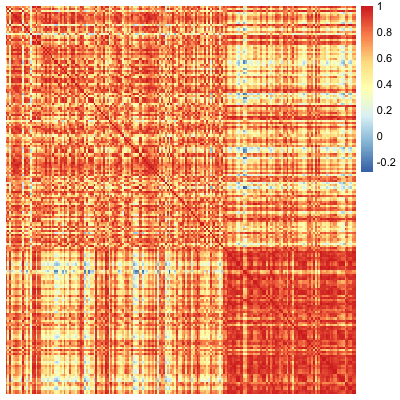

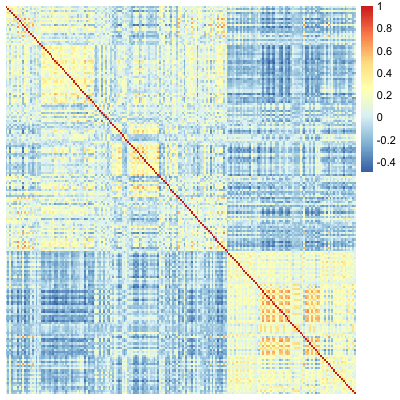

In [23]:
options(repr.plot.width = 5, repr.plot.height = 5)

a=pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F)
##options(repr.plot.width = 5, repr.plot.height = 5)
b=pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE)
##grid.arrange(a,b,ncol=2)

# Let's do some batch adjustments

## first, let's adjust cell type proportion

In [24]:
props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, cDC=cdc_prop, pDC=pdc_prop));

props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, cDC=cdc_sle_prop, pDC=pdc_sle_prop));
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, cDC=cdc_ucsf_healthy_prop, pDC=pdc_ucsf_healthy_prop));
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, cDC=cdc_broad_healthy_prop, pDC=pdc_broad_healthy_prop));


## second, let's adjust cell type specific expression

In [25]:
# pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
# cm_mean <- t(lm(t(cm_expr)~1)$fitted)
# th_mean <- t(lm(t(th_expr)~1)$fitted)
# b_mean <- t(lm(t(b_expr)~1)$fitted)
# nk_mean <- t(lm(t(nk_expr)~1)$fitted)
# ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
# tc_mean <- t(lm(t(tc_expr)~1)$fitted)
# cdc_mean <- t(lm(t(cdc_expr)~1)$fitted)
# pdc_mean <- t(lm(t(pdc_expr)~1)$fitted)

##joined_pivot$seq_batch_cov <- grep("immvar",joined_pivot$batch_cov)

modcombat = model.matrix(~disease_cov, data=joined_pivot);
# modcombat = model.matrix(~1, data=joined_pivot);

# pbmc_expr <- ComBat(dat=pbmc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# cm_expr <-  ComBat(dat=cm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# th_expr <-  ComBat(dat=th_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# b_expr <-  ComBat(dat=b_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# nk_expr <-  ComBat(dat=nk_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# ncm_expr <-  ComBat(dat=ncm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# tc_expr <-  ComBat(dat=tc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# cdc_expr <-  ComBat(dat=cdc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)
# pdc_expr <-  ComBat(dat=pdc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)#, mean.only=TRUE)


## let's remake the exprs and standardized versions

### all first

In [26]:
exprs_pbmc_counts <- array(c(cm_expr_pbmc_counts, th_expr_pbmc_counts, b_expr_pbmc_counts, nk_expr_pbmc_counts, ncm_expr_pbmc_counts, tc_expr_pbmc_counts, cdc_expr_pbmc_counts, pdc_expr_pbmc_counts),
               c(nrow(cm_expr_pbmc_counts) , ncol(cm_expr_pbmc_counts), 8),
               list(rownames(cm_expr_pbmc_counts),colnames(cm_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts <- array(c(cm_expr_ct_counts, th_expr_ct_counts, b_expr_ct_counts, nk_expr_ct_counts, ncm_expr_ct_counts, tc_expr_ct_counts, cdc_expr_ct_counts, pdc_expr_ct_counts),
               c(nrow(cm_expr_ct_counts) , ncol(cm_expr_ct_counts), 8),
               list(rownames(cm_expr_ct_counts),colnames(cm_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))

exprs_pbmc_counts_std <- array(c(cm_expr_pbmc_counts_std, th_expr_pbmc_counts_std, b_expr_pbmc_counts_std, nk_expr_pbmc_counts_std, ncm_expr_pbmc_counts_std, tc_expr_pbmc_counts_std, cdc_expr_pbmc_counts_std, pdc_expr_pbmc_counts_std),
               c(nrow(cm_expr_pbmc_counts_std) , ncol(cm_expr_pbmc_counts_std), 8),
               list(rownames(cm_expr_pbmc_counts_std),colnames(cm_expr_pbmc_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts_std <- array(c(cm_expr_ct_counts_std, th_expr_ct_counts_std, b_expr_ct_counts_std, nk_expr_ct_counts_std, ncm_expr_ct_counts_std, tc_expr_ct_counts_std, cdc_expr_ct_counts_std, pdc_expr_ct_counts_std),
               c(nrow(cm_expr_ct_counts_std) , ncol(cm_expr_ct_counts_std), 8),
               list(rownames(cm_expr_ct_counts_std),colnames(cm_expr_ct_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### SLE

In [27]:
cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

exprs_sle_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts, th_sle_expr_pbmc_counts, b_sle_expr_pbmc_counts, nk_sle_expr_pbmc_counts, ncm_sle_expr_pbmc_counts, tc_sle_expr_pbmc_counts, cdc_sle_expr_pbmc_counts, pdc_sle_expr_pbmc_counts),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_sle_ct_counts <- array(c(cm_sle_expr_ct_counts, th_sle_expr_ct_counts, b_sle_expr_ct_counts, nk_sle_expr_ct_counts, ncm_sle_expr_ct_counts, tc_sle_expr_ct_counts, cdc_sle_expr_ct_counts, pdc_sle_expr_ct_counts),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_pbmc_counts_std <- t(apply(cm_sle_expr_pbmc_counts,1,standardize))
th_sle_expr_pbmc_counts_std <- t(apply(th_sle_expr_pbmc_counts,1,standardize))
b_sle_expr_pbmc_counts_std <- t(apply(b_sle_expr_pbmc_counts,1,standardize))
nk_sle_expr_pbmc_counts_std <- t(apply(nk_sle_expr_pbmc_counts,1,standardize))
ncm_sle_expr_pbmc_counts_std <- t(apply(ncm_sle_expr_pbmc_counts,1,standardize))
tc_sle_expr_pbmc_counts_std <- t(apply(tc_sle_expr_pbmc_counts,1,standardize))
cdc_sle_expr_pbmc_counts_std <- t(apply(cdc_sle_expr_pbmc_counts,1,standardize))
pdc_sle_expr_pbmc_counts_std <- t(apply(pdc_sle_expr_pbmc_counts,1,standardize))

exprs_sle_std_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts_std, th_sle_expr_pbmc_counts_std, b_sle_expr_pbmc_counts_std, nk_sle_expr_pbmc_counts_std, ncm_sle_expr_pbmc_counts_std, tc_sle_expr_pbmc_counts_std, cdc_sle_expr_pbmc_counts_std, pdc_sle_expr_pbmc_counts_std),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_sle_expr_ct_counts_std <- t(apply(cm_sle_expr_ct_counts,1,standardize))
th_sle_expr_ct_counts_std <- t(apply(th_sle_expr_ct_counts,1,standardize))
b_sle_expr_ct_counts_std <- t(apply(b_sle_expr_ct_counts,1,standardize))
nk_sle_expr_ct_counts_std <- t(apply(nk_sle_expr_ct_counts,1,standardize))
ncm_sle_expr_ct_counts_std <- t(apply(ncm_sle_expr_ct_counts,1,standardize))
tc_sle_expr_ct_counts_std <- t(apply(tc_sle_expr_ct_counts,1,standardize))
cdc_sle_expr_ct_counts_std <- t(apply(cdc_sle_expr_ct_counts,1,standardize))
pdc_sle_expr_ct_counts_std <- t(apply(pdc_sle_expr_ct_counts,1,standardize))

exprs_sle_std_ct_counts <- array(c(cm_sle_expr_ct_counts_std, th_sle_expr_ct_counts_std, b_sle_expr_ct_counts_std, nk_sle_expr_ct_counts_std, ncm_sle_expr_ct_counts_std, tc_sle_expr_ct_counts_std, cdc_sle_expr_ct_counts_std, pdc_sle_expr_ct_counts_std),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

### UCSF healthy

In [28]:
cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

exprs_ucsf_healthy_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts, th_ucsf_healthy_expr_pbmc_counts, b_ucsf_healthy_expr_pbmc_counts, nk_ucsf_healthy_expr_pbmc_counts, ncm_ucsf_healthy_expr_pbmc_counts, tc_ucsf_healthy_expr_pbmc_counts, cdc_ucsf_healthy_expr_pbmc_counts, pdc_ucsf_healthy_expr_pbmc_counts),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ucsf_healthy_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts, th_ucsf_healthy_expr_ct_counts, b_ucsf_healthy_expr_ct_counts, nk_ucsf_healthy_expr_ct_counts, ncm_ucsf_healthy_expr_ct_counts, tc_ucsf_healthy_expr_ct_counts, cdc_ucsf_healthy_expr_ct_counts, pdc_ucsf_healthy_expr_ct_counts),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cm_ucsf_healthy_expr_pbmc_counts,1,standardize))
th_ucsf_healthy_expr_pbmc_counts_std <- t(apply(th_ucsf_healthy_expr_pbmc_counts,1,standardize))
b_ucsf_healthy_expr_pbmc_counts_std <- t(apply(b_ucsf_healthy_expr_pbmc_counts,1,standardize))
nk_ucsf_healthy_expr_pbmc_counts_std <- t(apply(nk_ucsf_healthy_expr_pbmc_counts,1,standardize))
ncm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(ncm_ucsf_healthy_expr_pbmc_counts,1,standardize))
tc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(tc_ucsf_healthy_expr_pbmc_counts,1,standardize))
cdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cdc_ucsf_healthy_expr_pbmc_counts,1,standardize))
pdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(pdc_ucsf_healthy_expr_pbmc_counts,1,standardize))

exprs_ucsf_healthy_std_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts_std, th_ucsf_healthy_expr_pbmc_counts_std, b_ucsf_healthy_expr_pbmc_counts_std, nk_ucsf_healthy_expr_pbmc_counts_std, ncm_ucsf_healthy_expr_pbmc_counts_std, tc_ucsf_healthy_expr_pbmc_counts_std, cdc_ucsf_healthy_expr_pbmc_counts_std, pdc_ucsf_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_ucsf_healthy_expr_ct_counts_std <- t(apply(cm_ucsf_healthy_expr_ct_counts,1,standardize))
th_ucsf_healthy_expr_ct_counts_std <- t(apply(th_ucsf_healthy_expr_ct_counts,1,standardize))
b_ucsf_healthy_expr_ct_counts_std <- t(apply(b_ucsf_healthy_expr_ct_counts,1,standardize))
nk_ucsf_healthy_expr_ct_counts_std <- t(apply(nk_ucsf_healthy_expr_ct_counts,1,standardize))
ncm_ucsf_healthy_expr_ct_counts_std <- t(apply(ncm_ucsf_healthy_expr_ct_counts,1,standardize))
tc_ucsf_healthy_expr_ct_counts_std <- t(apply(tc_ucsf_healthy_expr_ct_counts,1,standardize))
cdc_ucsf_healthy_expr_ct_counts_std <- t(apply(cdc_ucsf_healthy_expr_ct_counts,1,standardize))
pdc_ucsf_healthy_expr_ct_counts_std <- t(apply(pdc_ucsf_healthy_expr_ct_counts,1,standardize))

exprs_ucsf_healthy_std_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts_std, th_ucsf_healthy_expr_ct_counts_std, b_ucsf_healthy_expr_ct_counts_std, nk_ucsf_healthy_expr_ct_counts_std, ncm_ucsf_healthy_expr_ct_counts_std, tc_ucsf_healthy_expr_ct_counts_std, cdc_ucsf_healthy_expr_ct_counts_std, pdc_ucsf_healthy_expr_ct_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### broad healthy

In [29]:
cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

exprs_broad_healthy_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts, th_broad_healthy_expr_pbmc_counts, b_broad_healthy_expr_pbmc_counts, nk_broad_healthy_expr_pbmc_counts, ncm_broad_healthy_expr_pbmc_counts, tc_broad_healthy_expr_pbmc_counts, cdc_broad_healthy_expr_pbmc_counts, pdc_broad_healthy_expr_pbmc_counts),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_broad_healthy_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts, th_broad_healthy_expr_ct_counts, b_broad_healthy_expr_ct_counts, nk_broad_healthy_expr_ct_counts, ncm_broad_healthy_expr_ct_counts, tc_broad_healthy_expr_ct_counts, cdc_broad_healthy_expr_ct_counts, pdc_broad_healthy_expr_ct_counts),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_pbmc_counts_std <- t(apply(cm_broad_healthy_expr_pbmc_counts,1,standardize))
th_broad_healthy_expr_pbmc_counts_std <- t(apply(th_broad_healthy_expr_pbmc_counts,1,standardize))
b_broad_healthy_expr_pbmc_counts_std <- t(apply(b_broad_healthy_expr_pbmc_counts,1,standardize))
nk_broad_healthy_expr_pbmc_counts_std <- t(apply(nk_broad_healthy_expr_pbmc_counts,1,standardize))
ncm_broad_healthy_expr_pbmc_counts_std <- t(apply(ncm_broad_healthy_expr_pbmc_counts,1,standardize))
tc_broad_healthy_expr_pbmc_counts_std <- t(apply(tc_broad_healthy_expr_pbmc_counts,1,standardize))
cdc_broad_healthy_expr_pbmc_counts_std <- t(apply(cdc_broad_healthy_expr_pbmc_counts,1,standardize))
pdc_broad_healthy_expr_pbmc_counts_std <- t(apply(pdc_broad_healthy_expr_pbmc_counts,1,standardize))

exprs_broad_healthy_std_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts_std, th_broad_healthy_expr_pbmc_counts_std, b_broad_healthy_expr_pbmc_counts_std, nk_broad_healthy_expr_pbmc_counts_std, ncm_broad_healthy_expr_pbmc_counts_std, tc_broad_healthy_expr_pbmc_counts_std, cdc_broad_healthy_expr_pbmc_counts_std, pdc_broad_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_broad_healthy_expr_ct_counts_std <- t(apply(cm_broad_healthy_expr_ct_counts,1,standardize))
th_broad_healthy_expr_ct_counts_std <- t(apply(th_broad_healthy_expr_ct_counts,1,standardize))
b_broad_healthy_expr_ct_counts_std <- t(apply(b_broad_healthy_expr_ct_counts,1,standardize))
nk_broad_healthy_expr_ct_counts_std <- t(apply(nk_broad_healthy_expr_ct_counts,1,standardize))
ncm_broad_healthy_expr_ct_counts_std <- t(apply(ncm_broad_healthy_expr_ct_counts,1,standardize))
tc_broad_healthy_expr_ct_counts_std <- t(apply(tc_broad_healthy_expr_ct_counts,1,standardize))
cdc_broad_healthy_expr_ct_counts_std <- t(apply(cdc_broad_healthy_expr_ct_counts,1,standardize))
pdc_broad_healthy_expr_ct_counts_std <- t(apply(pdc_broad_healthy_expr_ct_counts,1,standardize))

exprs_broad_healthy_std_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts_std, th_broad_healthy_expr_ct_counts_std, b_broad_healthy_expr_ct_counts_std, nk_broad_healthy_expr_ct_counts_std, ncm_broad_healthy_expr_ct_counts_std, tc_broad_healthy_expr_ct_counts_std, cdc_broad_healthy_expr_ct_counts_std, pdc_broad_healthy_expr_ct_counts_std),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

## plot both after correcting for batch

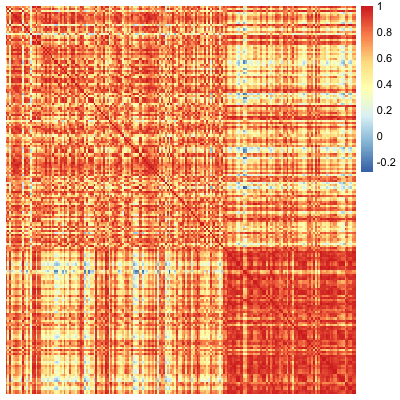

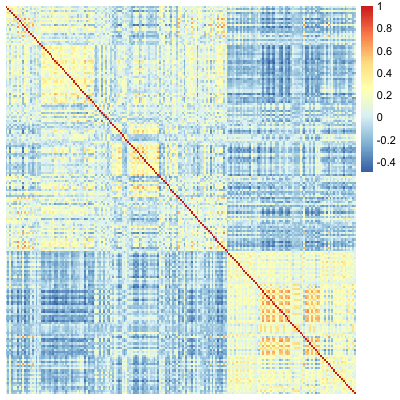

In [30]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F)
##options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE)

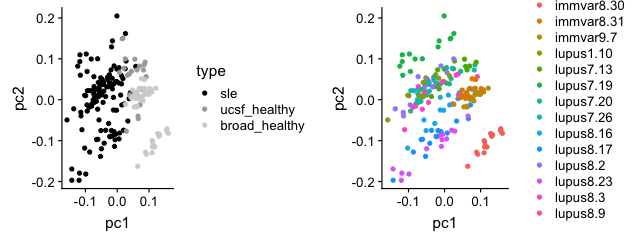

In [31]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

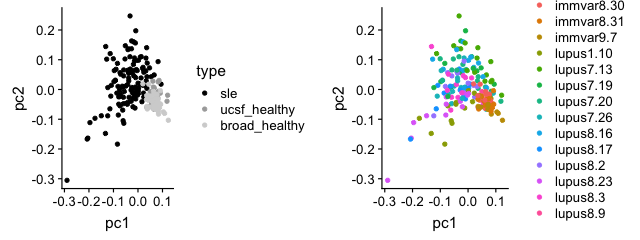

In [32]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

In [33]:
t(c(cor(colMeans(cm_expr_pbmc_counts), props[,"cM"]),cor(colMeans(th_expr_pbmc_counts), props[,"Th"]),cor(colMeans(tc_expr_pbmc_counts), props[,"Tc"]),cor(colMeans(nk_expr_pbmc_counts), props[,"NK"]),cor(colMeans(ncm_expr_pbmc_counts), props[,"ncM"]),cor(colMeans(pdc_expr_pbmc_counts), props[,"pDC"]),cor(colMeans(cdc_expr_pbmc_counts), props[,"cDC"])))

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
[1,] 0.9830407 0.9935128 0.9724716 0.9838961 0.9869857 0.9884214 0.9842348

In [34]:
# cor(colMeans(cm_expr_std), props[,"cM"])
# cor(colMeans(th_expr_std), props[,"Th"])
# cor(colMeans(tc_expr_std), props[,"Tc"])
# cor(colMeans(nk_expr_std), props[,"NK"])
# cor(colMeans(ncm_expr_std), props[,"ncM"])
# cor(colMeans(pdc_expr_std), props[,"pDC"])
# cor(colMeans(cdc_expr_std), props[,"cDC"])

In [35]:
cor(pbmc_expr["CD14",], props[,"cM"])
cor(pbmc_sle_expr["CD14",], props_sle[,"cM"])

cor(pbmc_expr_std["CD14",], props[,"cM"])
cor(pbmc_sle_expr_std["CD14",], props_sle[,"cM"])

[1] 0.7766897

[1] 0.7043726

[1] 0.7766897

[1] 0.7043726

# Figure 2A - heatmap

In [36]:
cell_types <- c("PBMC","cM","ncM", "cDC","pDC","T4","T8","NK","B")

pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "manhattan"), method="complete")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "manhattan"), method="complete")

all_expr_pbmc_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_pbmc_counts_std[,pbmc_col_clust$order])


all_expr_pbmc_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_pbmc_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_pbmc_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_pbmc_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_pbmc_counts[,pbmc_col_clust$order],
                      th=th_expr_pbmc_counts[,pbmc_col_clust$order],
                      tc=tc_expr_pbmc_counts[,pbmc_col_clust$order],
                      nk=nk_expr_pbmc_counts[,pbmc_col_clust$order],
                      b=b_expr_pbmc_counts[,pbmc_col_clust$order]
                      )

all_expr_pbmc_counts_sig <- all_expr_pbmc_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_pbmc_counts_std_sig <- all_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                                       
all_expr_ct_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_ct_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_ct_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_ct_counts_std[,pbmc_col_clust$order])


all_expr_ct_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_ct_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_ct_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_ct_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_ct_counts[,pbmc_col_clust$order],
                      th=th_expr_ct_counts[,pbmc_col_clust$order],
                      tc=tc_expr_ct_counts[,pbmc_col_clust$order],
                      nk=nk_expr_ct_counts[,pbmc_col_clust$order],
                      b=b_expr_ct_counts[,pbmc_col_clust$order]
                      )

all_expr_ct_counts_sig <- all_expr_ct_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_ct_counts_std_sig <- all_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]

                                     
                                     
ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);


ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr_pbmc_counts))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_pbmc_counts_std);


In [37]:
# options(repr.plot.width = 16, repr.plot.height = 16)

# breaksList = seq(-2, 2, by = .1)
# pheatmap_out <- pheatmap(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
#          cluster_rows=T, cluster_cols=F,annotation_col = ct_annotation_one[pbmc_col_clust$order,],#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), 
#                          cutree_rows=8, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",# Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList) # Sets the breaks of the color scale as in breaksList

In [38]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)
sum(crow_annotation$Crow)

[1] 25

In [39]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [40]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

annotation_colors = list(
    type = c(PBMC="#000000", cM="#E58606", ncM="#5D69B1", cDC="#52BCA3", pDC="#99C945", T4="#CC61B0", T8="#24796C", NK="#DAA51B", B="#764E9F"),
    disease_pop_cov = c(healthyWHITE="#D82B29", sleWHITE="#1B78B6", sleASIAN="#F57F20")
)

# pheatmap_std_out <- pheatmap(all_expr_pbmc_counts_std,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors = annotation_colors,#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
#                          cutree_rows=8, 
#                          scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan", filename="expr_std_heatmap.png",
#                             width=10, height=10, dpi=600)
# options(repr.plot.width = 10, repr.plot.height = 4)



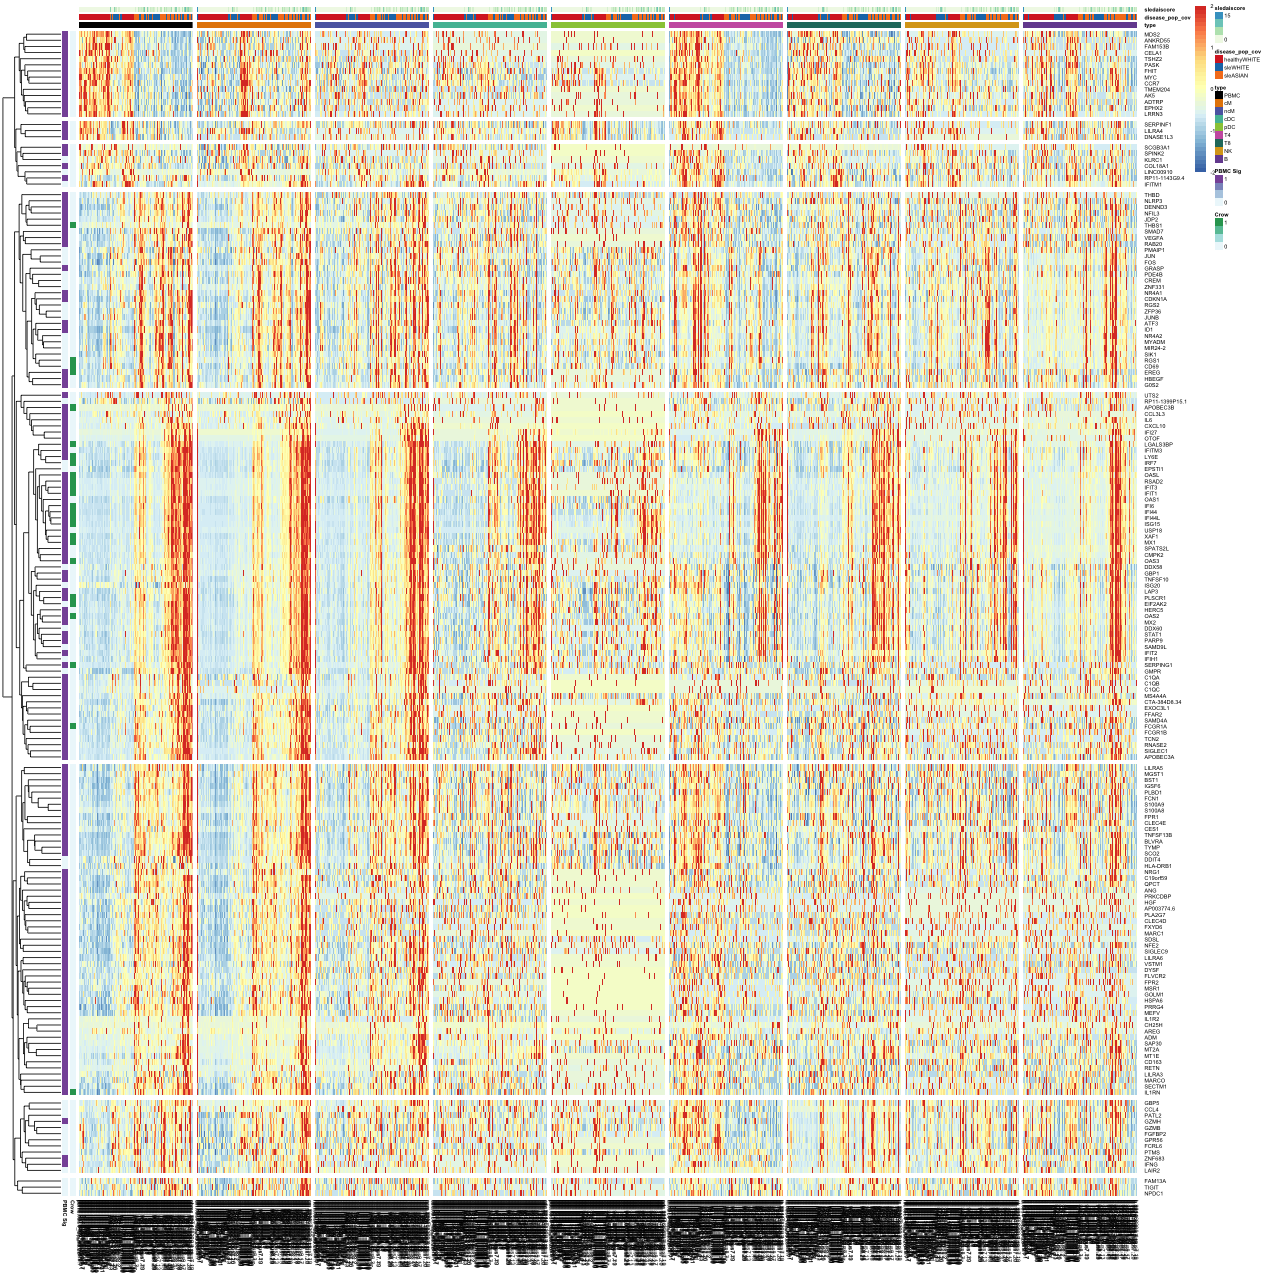

In [41]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .1)


mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig,1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_std_out <- pheatmap(mat,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
                         cutree_rows=8, 
                         scale="none",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan",
                            width=10, height=10)
options(repr.plot.width = 10, repr.plot.height = 4)



## first let's run clustering using pheatmap and save the ordering of genes

In [42]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# pheatmap_ct_counts_out <- pheatmap(log(all_expr_ct_counts_sig+1)[,-c(1:187)],
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation[-c(1:187),], annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*(length(cell_types)-1),ncol(cm_expr_ct_counts)),
#                          cutree_rows=10, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")


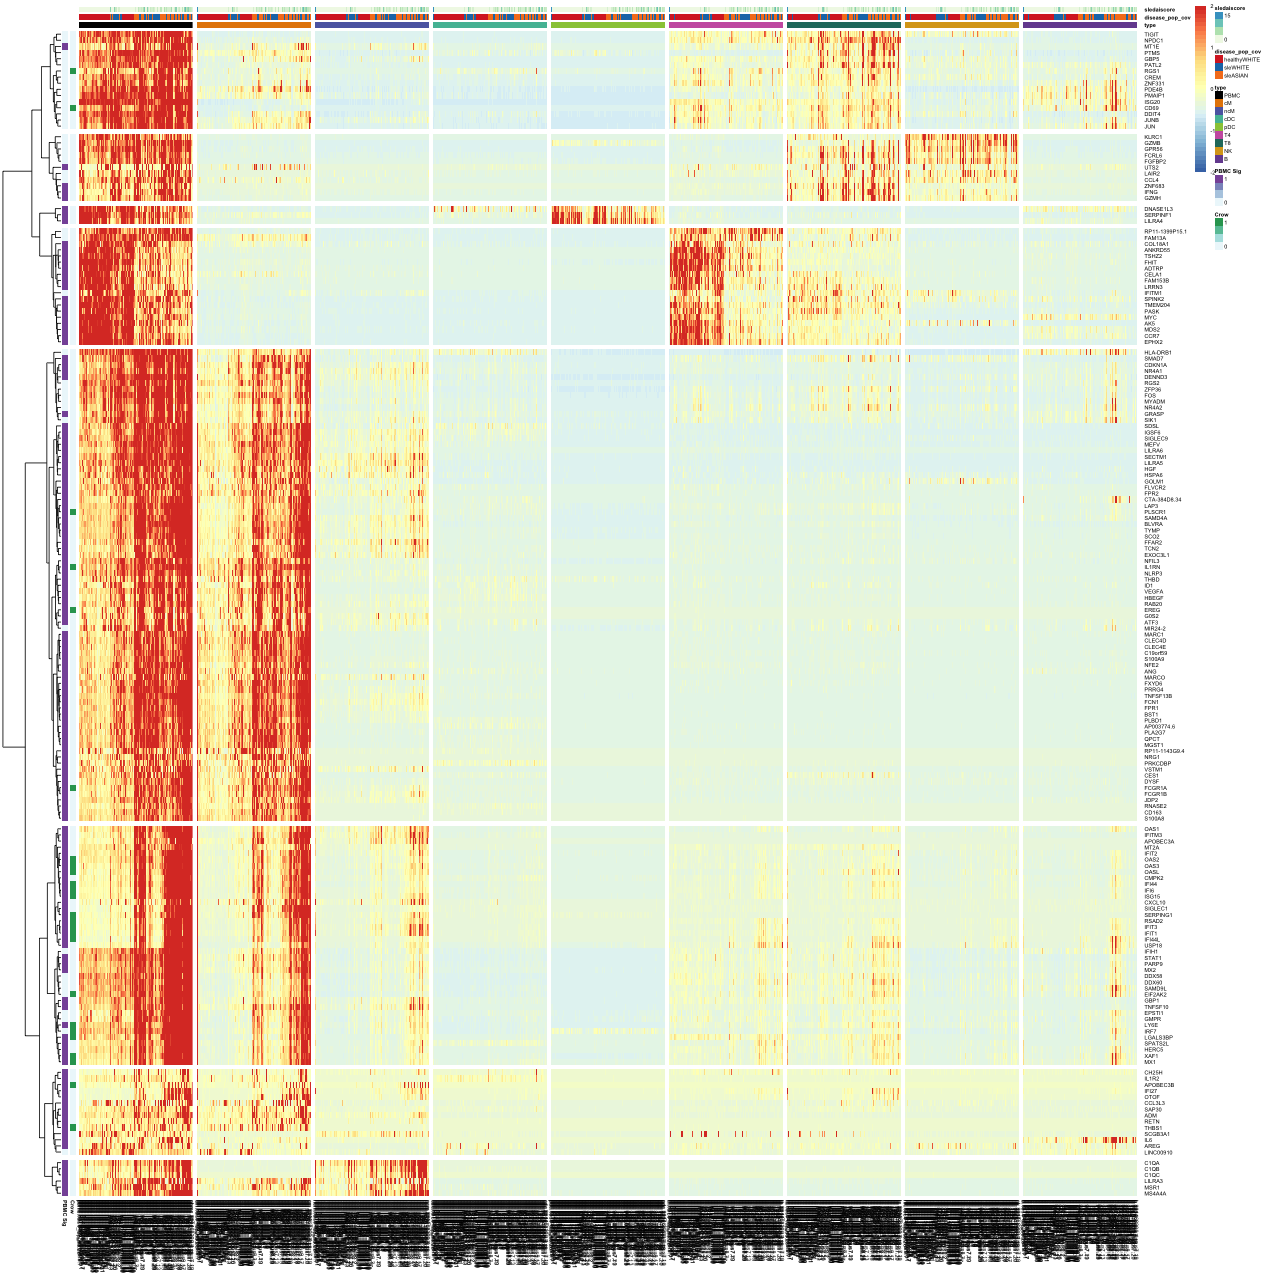

In [43]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .1)

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig,1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
                         cutree_rows=8, 
                         scale="none",fontsize=5,clustering_method="ward.D2",clustering_distance_row="manhattan",
                            width=10, height=10)
options(repr.plot.width = 10, repr.plot.height = 4)


# pheatmap_pbmc_counts_out <- pheatmap(mat,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*(length(cell_types)-1),ncol(cm_expr_pbmc_counts)),
#                          cutree_rows=8,
#                          scale="row",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan")

## now let's plot it by ordering the clusters in a reasonable way

In [44]:
cuttree_out_unordered <- cutree(pheatmap_pbmc_counts_out$tree_row, k = 8)
t(unique(cuttree_out_unordered[pheatmap_pbmc_counts_out$tree_row$order]))

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] 8    7    3    1    2    4    5    6

In [45]:
cuttree_out_unordered[which(cuttree_out_unordered==8)] <- "T8_1";
cuttree_out_unordered[which(cuttree_out_unordered==7)] <- "T8_2";
cuttree_out_unordered[which(cuttree_out_unordered==3)] <- "pDC";
cuttree_out_unordered[which(cuttree_out_unordered==1)] <- "T4";
cuttree_out_unordered[which(cuttree_out_unordered==2)] <- "Mono";
cuttree_out_unordered[which(cuttree_out_unordered==4)] <- "Pan";
cuttree_out_unordered[which(cuttree_out_unordered==5)] <- "Misc";
cuttree_out_unordered[which(cuttree_out_unordered==6)] <- "ncM";

# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";
cuttree_out_unordered <- factor(cuttree_out_unordered, levels=c("Pan","Mono","ncM","pDC","T4","T8_1","T8_2","Misc"), ordered=T)
cuttree_out <- cuttree_out_unordered[order(cuttree_out_unordered)];

##cuttree_out <- cuttree_out[pheatmap_pbmc_counts_out$tree_row$order];


# cuttree_out[which(cuttree_out==7)] <- "T3";
# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";

cuttree_gene_names <- names(cuttree_out);
cuttree_out <- data.frame(cuttree_gene_names,cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
cuttree_out <- as.data.frame(cuttree_out);
##cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
cuttree_out[,"gene"] <- as.character(cuttree_out[,"gene"])
write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

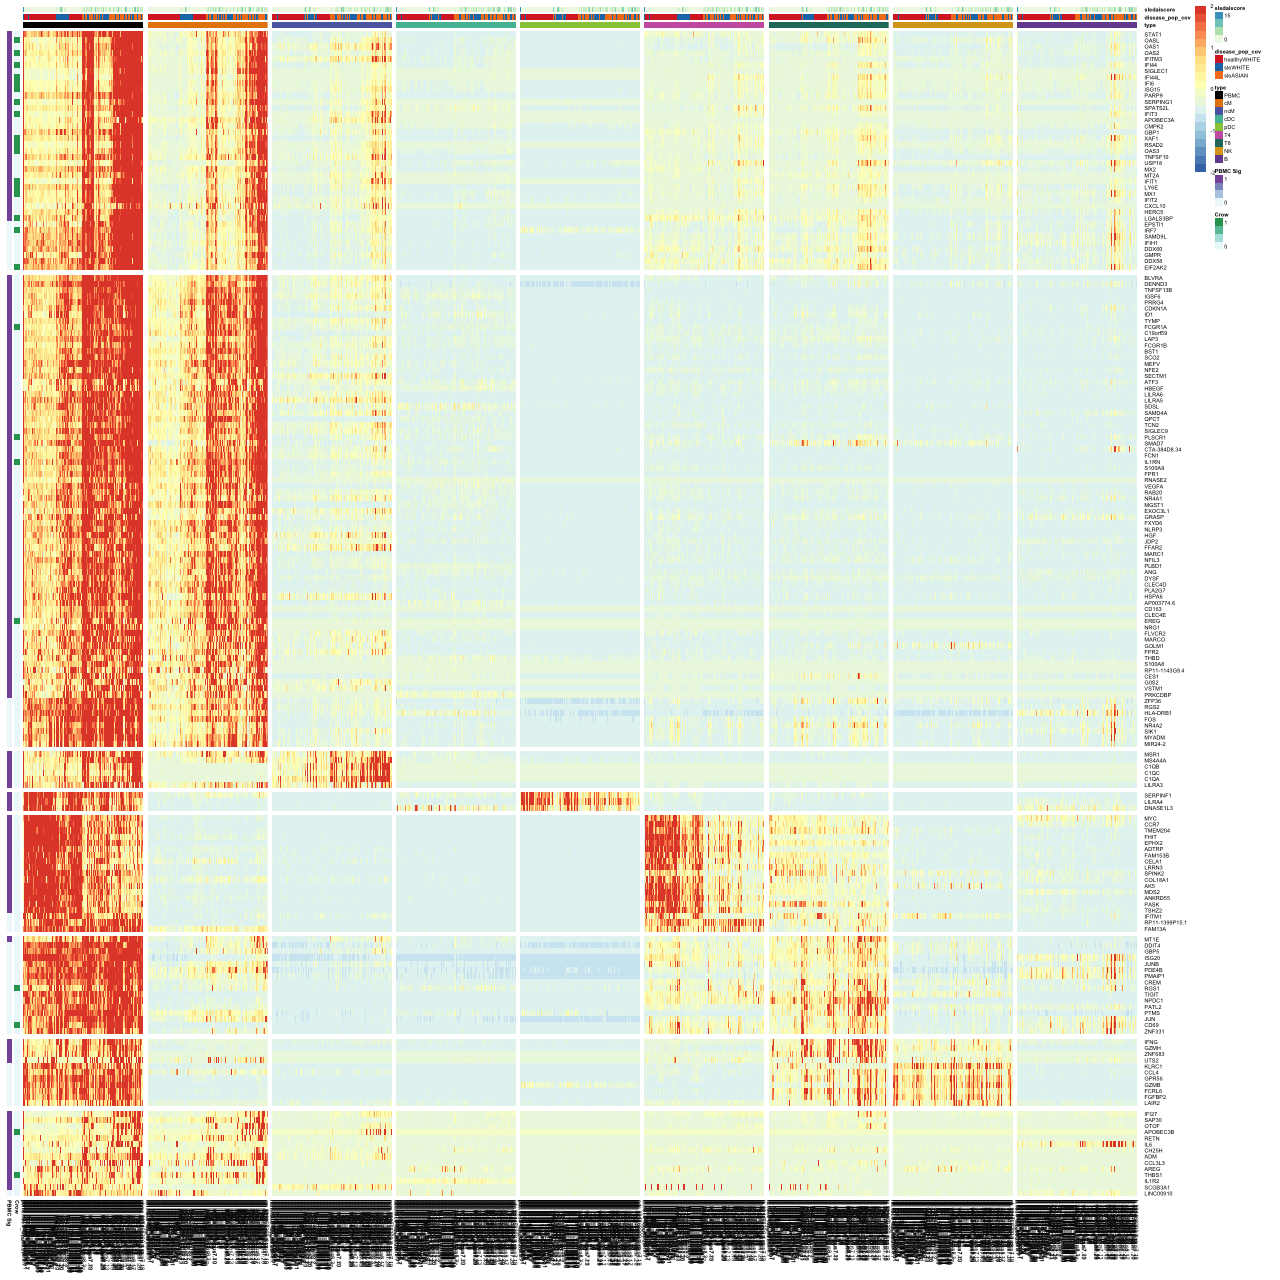

In [46]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2.8, 2.8, by = .2)

options(repr.plot.width = 16, repr.plot.height = 16)
min = -2;
max = 2;
breaksList = c(seq(-2, 2, by = .2))

# logged <- log(all_expr_pbmc_counts_sig+1)[cuttree_out$gene,];
# logged[which(logged>max)] = max;
# logged[which(logged<min)] = min;

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
        gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
      gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                   scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="expr_pbmc_counts_heatmap.png")


options(repr.plot.width = 10, repr.plot.height = 4)

In [47]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene[cuttree_out$cluster=="Pan"])))

[1] 17

In [48]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene[cuttree_out$cluster=="Mono"])))

[1] 4

In [49]:
length(na.omit(match(rownames(row_annotations)[row_annotations$Crow==1],cuttree_out$gene)))

[1] 25

In [50]:
cuttree_out$gene[cuttree_out$cluster=="T8_1"]

[1] "MT1E"   "DDIT4"  "GBP5"   "ISG20"  "JUNB"   "PDE4B"  "PMAIP1" "CREM"  
 [9] "RGS1"   "TIGIT"  "NPDC1"  "PATL2"  "PTMS"   "JUN"    "CD69"   "ZNF331"

In [51]:
cuttree_out$gene[cuttree_out$cluster=="T8_2"]

[1] "IFNG"   "GZMH"   "ZNF683" "UTS2"   "KLRC1"  "CCL4"   "GPR56"  "GZMB"  
 [9] "FCRL6"  "FGFBP2" "LAIR2"

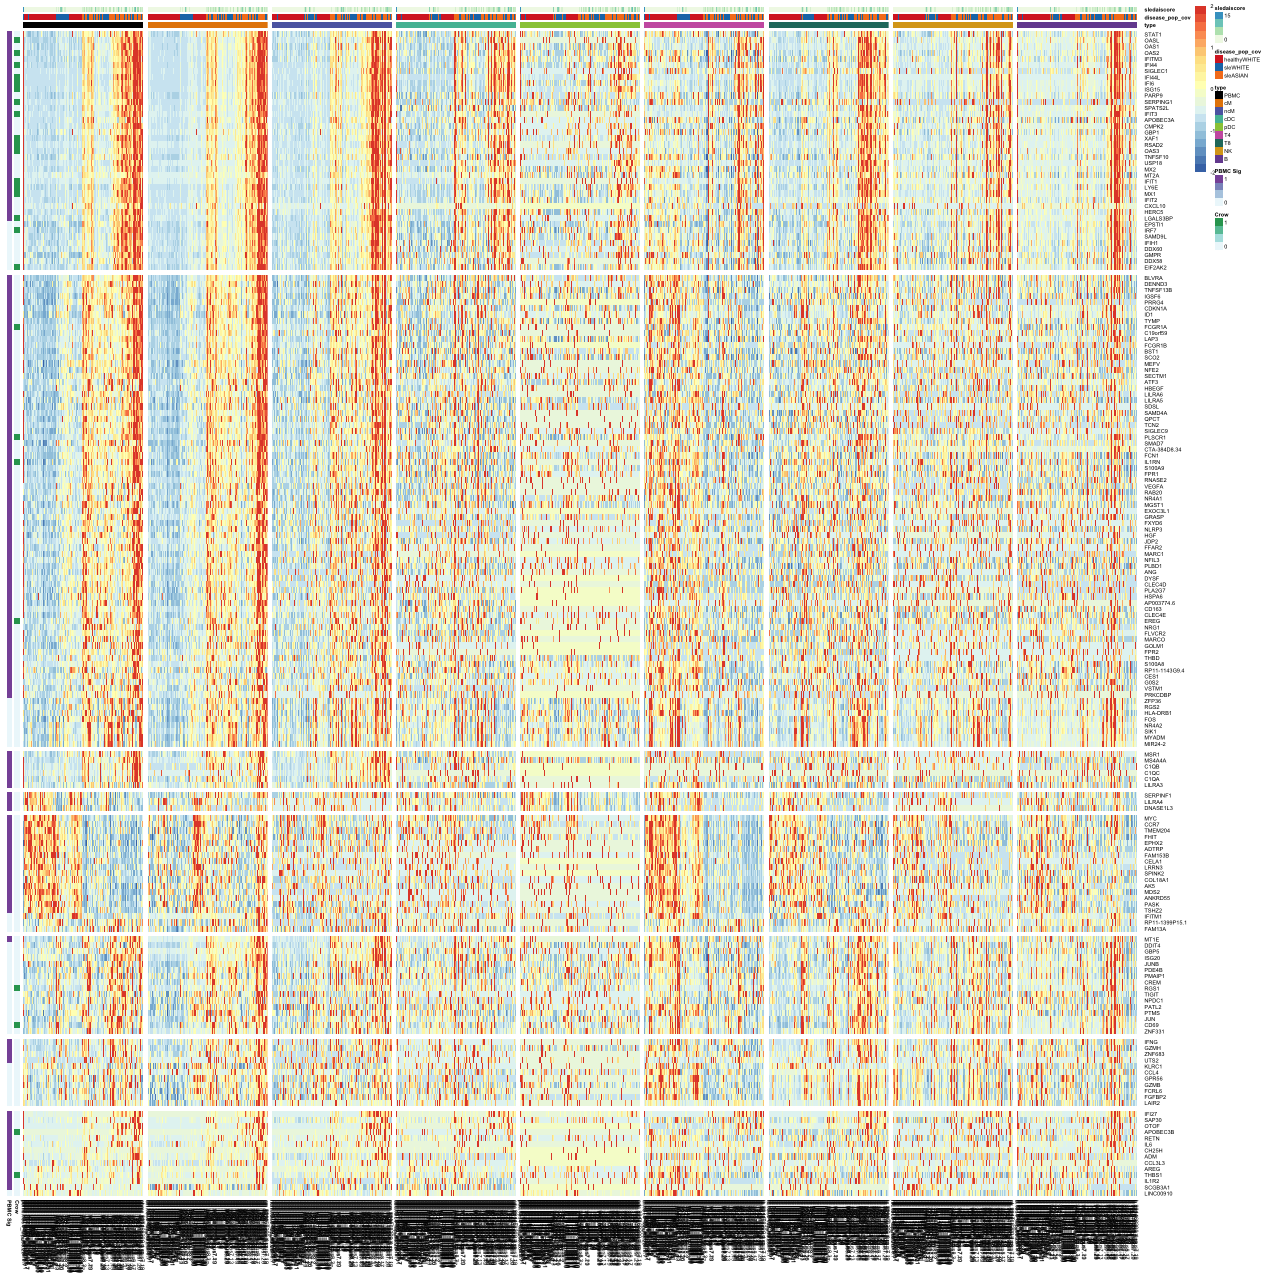

In [52]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2.8, 2.8, by = .2)

options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .2)


mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;


pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="expr_ct_counts_heatmap.png")
options(repr.plot.width = 10, repr.plot.height = 4)

In [53]:
# # options(repr.plot.width = 16, repr.plot.height = 16)
# # breaksList = seq(-2.8, 2.8, by = .2)

# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

# pheatmap_ct_counts_out <- pheatmap(props,
#          cluster_rows=pheatmap_pbmc_counts_out$tree_row, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
#                          cutree_rows=15, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

# pheatmap_ct_counts_out <- pheatmap(props,
#          cluster_rows=pheatmap_pbmc_counts_out$tree_row, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
#                          cutree_rows=15, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename="props_heatmap.png")
# options(repr.plot.width = 10, repr.plot.height = 4)

## make some volcano plots

In [54]:
options(repr.plot.width = 4, repr.plot.height = 4)
pbmc_deseq$ifn=pbmc_deseq$V1 %in% ifn_crow$V1
pbmc_deseq$sig=rep("cnot significant",nrow(pbmc_deseq))
pbmc_deseq$sig[match(deseq_sig_genes, pbmc_deseq$V1)]="bct_sig";
pbmc_deseq$sig[match(pbmc_deseq_sig_genes, pbmc_deseq$V1)]="apbmc_sig";

pbmc_deseq <- pbmc_deseq[order(pbmc_deseq$sig,decreasing=T),]
# !(abs(pbmc_deseq$log2FoldChange)>1) & (which(pbmc_deseq$qval < 0.01))

lim=max(abs(pbmc_deseq$log2FoldChange)) + 0.2
min_lim=-lim

##pdf(paste(ct, '.volcano.pdf', sep=''), useDingbats=F)
g = ggplot(pbmc_deseq, aes(x=log2FoldChange, y=-log10(pvalue), color=sig))+ theme_linedraw()+theme(legend.position="none") + xlim(-4.5, 4.5) + geom_point()+geom_point(data=pbmc_deseq[pbmc_deseq$ifn,],
             pch=21, fill=NA, size=4, colour="black", stroke=1)+scale_color_grey()+scale_fill_grey()
ggsave(g, filename="pbmc_deseq.png", width=3, height=3, dpi=300)
##dev.off()


Warning message:
“Removed 8 rows containing missing values (geom_point).”

## More principled way to cut the tree and label the specific signatures

In [55]:
# cuttree_out <- cutree(pheatmap_pbmc_counts_out$tree_row, k = 10)
# cuttree_out <- cuttree_out[pheatmap_pbmc_counts_out$tree_row$order];
# # cuttree_out[which(cuttree_out==7)] <- "T3";
# # cuttree_out[which(cuttree_out==1)] <- "T1";
# # cuttree_out[which(cuttree_out==5)] <- "Mono";
# # cuttree_out[which(cuttree_out==8)] <- "T2";
# # cuttree_out[which(cuttree_out==2)] <- "Mye1";
# # cuttree_out[which(cuttree_out==6)] <- "Pan";
# # cuttree_out[which(cuttree_out==3)] <- "Lymph";
# # cuttree_out[which(cuttree_out==4)] <- "Mye2";

# cuttree_gene_names <- names(cuttree_out);
# cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
# colnames(cuttree_out) <- c("gene","cluster")
# cuttree_out <- as.data.frame(cuttree_out);
# cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
# write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [56]:
# cuttree_out <- cutree(pheatmap_std_out$tree_row, k = 8)
# cuttree_out <- cuttree_out[pheatmap_std_out$tree_row$order];
# cuttree_out[which(cuttree_out==7)] <- "T3";
# cuttree_out[which(cuttree_out==1)] <- "T1";
# cuttree_out[which(cuttree_out==5)] <- "Mono";
# cuttree_out[which(cuttree_out==8)] <- "T2";
# cuttree_out[which(cuttree_out==2)] <- "Mye1";
# cuttree_out[which(cuttree_out==6)] <- "Pan";
# cuttree_out[which(cuttree_out==3)] <- "Lymph";
# cuttree_out[which(cuttree_out==4)] <- "Mye2";

# cuttree_gene_names <- names(cuttree_out);
# cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
# colnames(cuttree_out) <- c("gene","cluster")
# cuttree_out <- as.data.frame(cuttree_out);
# cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
# write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [57]:
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Pan"]), file="Pan.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mye2"]), file="Mye2.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mye1"]), file="Mye1.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Mono"]), file="Mono.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T1"]), file="T1.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T2"]), file="T2.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="T3"]), file="T3.txt", row.names=F, col.names=F, quote=F, sep=",")
# write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Lymph"]), file="Lymph.txt", row.names=F, col.names=F, quote=F, sep=",")

# write.table(as.character(cuttree_out$gene), file="All.txt", row.names=F, col.names=F, quote=F, sep=",")



# Figure 2B - correlogram to show coexpressed genes

In [58]:
# no_pbmc_cor <- cor(t(all_expr_sig[,-c(1,ncol(pbmc_expr))]))
# options(repr.plot.width = 6, repr.plot.height = 6)
# pheatmap(no_pbmc_cor,
#          cluster_rows=pheatmap_out$tree_row, cluster_cols=pheatmap_out$tree_row, #annotation_row = kmeans_annotation,
#          fontsize=3)
# options(repr.plot.width = 4, repr.plot.height = 4)

In [59]:
# cor(joined_pivot$sledaiscore, joined_pivot$cM)
# cor(joined_pivot_sle$sledaiscore, joined_pivot_sle$cM)
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")], joined_pivot_sle$cM[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")])
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")], joined_pivot_sle$cM[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")])
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(deseq_sig_genes,rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene,rownames(pbmc_sle_expr_std)),]))
# cor(joined_pivot_sle$sledaiscore, colMeans(pbmc_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Lymph"],rownames(pbmc_sle_expr_std)),]))


# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")], colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),])[which(joined_pivot_sle$disease_pop_cov=="sleWHITE")])
# cor(joined_pivot_sle$sledaiscore[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")], colMeans(cm_sle_expr_std[match(cuttree_out$gene[cuttree_out$cluster=="Pan"],rownames(pbmc_sle_expr_std)),])[which(joined_pivot_sle$disease_pop_cov=="sleASIAN")])

# Figure 2C: Proportion of variance explained


First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Let's define some useful functions

## Processing all - now, let's fit with -1 but we need to standardize the outcome

In [60]:
# i = 347;

# expr <- pbmc_expr;
# props <- props;
# exprs <- exprs;
# expr_res <- pbmc_expr;
# cov_prop_mat <- cov(props);

# model <- lm(expr[i,]~props-1)
# coef = summary(model)$coef[,1];
# expr_res[i,] <- residuals(model);

# vars_prop = NULL;
        
# for(j in 1:ncol(props)) {
#             var_j_prop = sum(cov_prop_mat[j,]*coef[j]*coef);
#             vars_prop <- c(vars_prop, var_j_prop);
#         }
        
#         r2s_prop = vars_prop/sum(vars_prop);
        
#         r2_prop = sum(vars_prop)/var(expr[i,]);
#         r2_prop_adj = r2_prop-(1-r2_prop)*(ncol(props))/(ncol(expr)-ncol(props)-1);

#         cov_expr_mat <- cov(exprs[i,,]);
        
#         vars_expr <- NULL;
#         covars_expr <- NULL;
        
#         for(j in 1:dim(exprs)[[3]]) {
#             var_j_expr = diag(cov_expr_mat)[[j]]; ##sum(cov_expr_mat[j,]);
#             covar_j_expr = sum(cov_expr_mat[j,])-diag(cov_expr_mat)[[j]];
#             vars_expr <- c(vars_expr, var_j_expr);
#             covars_expr <- c(covars_expr, covar_j_expr)
#         }
        
#         if(i == 1){
#             print(cov_expr_mat);
#             print(var_j_expr)};
        
#         r2s_expr = vars_expr/sum(vars_expr);
#         r2_expr = sum(vars_expr)/var(expr_res[i,]);
#         r2_expr_adj = r2_expr-(1-r2_expr)*dim(exprs)[[3]]/(ncol(expr)-dim(exprs)[[3]]-1);
    
#         r2s_covar_expr = covars_expr/sum(covars_expr);
#         r2_covar_expr = sum(covars_expr)/var(expr_res[i,]);
#         r2_covar_expr_adj = r2_covar_expr-(1-r2_covar_expr)*dim(exprs)[[3]]/(ncol(expr)-dim(exprs)[[3]]-1);
    
# var(expr[i,])
# t(vars_expr)
# t(covars_expr)
# sum(t(vars_expr))/var(expr[i,])
# sum(t(covars_expr))/var(expr[i,])
# sum(t(covars_expr))/var(expr[i,])

# sum(cov_expr_mat[j,])

In [61]:
# source("helper_functions.R")
# output_prop_expr_noint_noah <- model_prop_expr_noah(pbmc_expr, props, exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_noah <- output_prop_expr_noint_noah[[1]];
# output_expr_noint_noah <- output_prop_expr_noint_noah[[2]];
# output_covar_expr_noint_noah <- output_prop_expr_noint_noah[[3]];

In [62]:
# mean(output_prop_noint_noah[,"total r2"])
# mean(output_expr_noint_noah[,"total r2"])
# mean(output_covar_expr_noint_noah[,"total r2"])

In [63]:
# t(output_expr_noint_noah[347,])

# write.table(pbmc_expr["CD14",],file="pbmc.counts");
# write.table(props, file="cell.props")
# write.table(exprs["CD14",,], file="ct.counts")
# write.table(pbmc_total[match(colnames(exprs),names(pbmc_total))], file="cell.counts")

In [64]:
source("helper_functions.R")
output_prop_expr_noint <- model_prop_expr_noah(pbmc_expr, props, exprs_pbmc_counts);
# output_prop_noint <- model_prop(pbmc_expr_std, props);
# output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
output_prop_noint <- output_prop_expr_noint[[1]];
output_expr_noint <- output_prop_expr_noint[[4]];
output_expr_pbmc_count_noint <- output_prop_expr_noint[[7]];


In [65]:
head(output_expr_pbmc_count_noint,20)

cM          Th         B          NK         ncM        
RP11-34P13.7   28.7611058 20.4033534 12.1063634  3.0628939  7.37121082
AL627309.1     88.7455785 -0.3914017  0.1698123  0.6956209  6.26026402
AP006222.2     21.9057258  8.6335274 12.3030491  9.4408847  9.37805797
RP4-669L17.10  22.2628132 28.7940742 12.5594256  7.0306608  5.67001437
RP11-206L10.3  59.9348996 10.7804229  6.1309272  1.8299756  9.20809170
RP11-206L10.2  38.3763787 18.9891014  9.1996772  5.2779480  5.56539900
RP11-206L10.9  14.9263830 26.0979697 12.4424812 11.2952642  2.78856101
FAM87B         41.9163599 11.9289240  3.8930375  2.6281736 13.59137993
LINC00115      29.9082515 15.0700666 11.6628934  8.2799110  9.16729957
FAM41C         10.5800600 26.2193563 25.0426213  7.5547367  3.41125843
NOC2L         -10.8990626 40.7174749 22.9308895 15.8192263  1.77742079
KLHL17         40.2991465 14.0445250 10.2591442  4.8158170  6.28535775
PLEKHN1        46.2089999 12.9805570  1.1767838  4.8183785  1.15760154
RP11-54O7.17   51.2145546  0.8686321  0.9248554  0.4729582 39.62180893
HES4           18.5489891  0.6745331  0.3722400  1.6721167 77.06412546
ISG15          57.0612916  4.9822957  3.6514975  3.0250080 14.42138810
AGRN           76.5496653  0.6921591  4.9573154  0.9215522  4.79981215
C1orf159       20.6762116 23.9727171  9.4155301 11.5629654  6.60020962
TTLL10          2.0843189 14.1951604 24.1470714 28.5382427  0.54387204
TNFRSF18        0.2660987  5.3863006  2.0716607 69.1365234 -0.04206811
              Tc         cDC         pDC         total r2  adj r2   
RP11-34P13.7  20.5643095  1.73903860  0.86815898  94.87643  94.64616
AL627309.1     2.4581733  0.59530465  0.19661902  98.72997  98.67289
AP006222.2    22.9701467  2.08065345  0.46001242  87.17206  86.59552
RP4-669L17.10 15.9007584  2.87615869  0.87250451  95.96641  95.78512
RP11-206L10.3  7.5679960  0.65369157  1.96478227  98.07079  97.98408
RP11-206L10.2 17.0226044  3.40901056  0.79619974  98.63632  98.57503
RP11-206L10.9 21.7625018  4.56084545  2.85003951  96.72405  96.57681
FAM87B        20.7851211  5.37181721  0.11440497 100.22922 100.23952
LINC00115     20.1689272  2.63747330  0.32241838  97.21724  97.09217
FAM41C        19.9955256  2.31768214  3.08309973  98.20434  98.12364
NOC2L         25.5251520 -0.25969664  0.69588590  96.30729  96.14133
KLHL17        22.7533146  2.63535019  0.53976381 101.63242 101.70579
PLEKHN1       29.0376834  1.86655784 -0.01596529  97.23060  97.10613
RP11-54O7.17   3.8542322  1.51633159  1.12628743  99.59966  99.58167
HES4           0.7991646  0.17102594  0.14272085  99.44492  99.41997
ISG15          8.8974900  1.75288842  0.29641187  94.08827  93.82258
AGRN           6.9636933  1.68108824  0.23500617  96.80029  96.65648
C1orf159      25.0704727  0.73732000  1.22624804  99.26167  99.22849
TTLL10        24.4869928  0.53139670  0.25800956  94.78506  94.55069
TNFRSF18      19.1703812 -0.07329531  0.11136239  96.02696  95.84840

In [66]:
# output_prop_expr_noint_prop_rand <- model_prop_expr_noah(pbmc_expr, props[sample(1:nrow(props)),], exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_prop_rand <- output_prop_expr_noint_prop_rand[[1]];
# output_expr_noint_prop_rand <- output_prop_expr_noint_prop_rand[[2]];
# mean(output_prop_noint_prop_rand[,"adj prop_expr r2"])

In [67]:
# output_prop_expr_noint_expr_rand <- model_prop_expr_noah(pbmc_expr, props, exprs[,sample(dimnames(exprs)[[2]]),]);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_expr_rand <- output_prop_expr_noint_expr_rand[[1]];
# output_expr_noint_expr_rand <- output_prop_expr_noint_expr_rand[[2]];
# mean(output_prop_noint_expr_rand[,"adj prop_expr r2"])

In [68]:
# output_prop_expr_noint_both_rand <- model_prop_expr_noah(pbmc_expr[,sample(colnames(pbmc_expr))], props, exprs);
# # output_prop_noint <- model_prop(pbmc_expr_std, props);
# # output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);
# output_prop_noint_both_rand <- output_prop_expr_noint_both_rand[[1]];
# output_expr_noint_both_rand <- output_prop_expr_noint_both_rand[[2]];
# mean(output_prop_noint_both_rand[,"adj prop_expr r2"])

## testing out nnls fit

In [69]:
# model_lm <- lm(pbmc_expr_std[407,]~props+exprs_std[407,,]-1)
# ##model_nnls <- nnls(cbind(props,exprs_std[407,,]), pbmc_expr_std[407,])
# model_nnls <- nnls(cbind(props), pbmc_expr_std[407,])

# cov_mat <- cov(cbind(props, exprs_std[407,,]));

# vars_lm <- NULL;
# coef = summary(model_lm)$coef[,1]
# for(j in 1:(ncol(props)+dim(exprs)[[3]])) {
#             var_j = sum(cov_mat[j,]*coef[j]*coef);
#             vars_lm <- c(vars_lm, var_j);
#         }

# vars_nnls <- NULL;
# coef = model_nnls$x
# # for(j in 1:(ncol(props)+dim(exprs)[[3]])) {
# #             var_j = sum(cov_mat[j,]*coef[j]*coef);
# #             vars_nnls <- c(vars_nnls, var_j);
# #         }

# for(j in 1:(ncol(props))) {
#             var_j = sum(cov_mat[j,]*coef[j]*coef);
#             vars_nnls <- c(vars_nnls, var_j);
#         }

# vars_lm/sum(vars_lm)*100

## Processing SLE

In [70]:
output_sle_prop_expr_noint <- model_prop_expr_noah(pbmc_sle_expr, props_sle, exprs_sle_pbmc_counts);
# output_sle_prop_noint <- model_prop(pbmc_sle_expr_std, props_sle);
# output_sle_expr_noint <- model_expr(pbmc_sle_expr_std, exprs_sle_std);
output_sle_prop_noint <- output_sle_prop_expr_noint[[1]];
output_sle_expr_noint <- output_sle_prop_expr_noint[[4]];
output_sle_expr_pbmc_count_noint <- output_sle_prop_expr_noint[[7]];

In [71]:
# output_sle_prop_noint_small <- model_prop(pbmc_sle_expr_std[1:100,], props_sle);
# output_sle_expr_noint_small <- model_expr(pbmc_sle_expr_std[1:100,], exprs_sle_std);

### Downsampled SLE to 46 samples

In [72]:
dim(props_sle)

[1] 118   8

In [73]:
## including dc analysis
##N <- 22;
samples_asian <- which(joined_pivot$disease_pop_cov=="sleASIAN")
samples_white <- which(joined_pivot$disease_pop_cov=="sleWHITE")

## including dc analysis
output_sle_asian_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_asian], props[samples_asian,], exprs_pbmc_counts[,samples_asian,]);
# output_sle_asian_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,]);
# output_sle_asian_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_asian], exprs_sle_std[,samples_asian,]);
output_sle_asian_prop_noint <- output_sle_asian_prop_expr_noint[[1]];
output_sle_asian_expr_noint <- output_sle_asian_prop_expr_noint[[4]];
output_sle_asian_expr_pbmc_count_noint <- output_sle_asian_prop_expr_noint[[7]];

output_sle_white_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_white], props[samples_white,], exprs_pbmc_counts[,samples_white,]);
# output_sle_white_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,]);
# output_sle_white_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_white], exprs_sle_std[,samples_white,]);
output_sle_white_prop_noint <- output_sle_white_prop_expr_noint[[1]];
output_sle_white_expr_noint <- output_sle_white_prop_expr_noint[[4]];
output_sle_white_expr_pbmc_count_noint <- output_sle_white_prop_expr_noint[[7]];

# samples <- sample(1:ncol(pbmc_sle_expr_std), N)
# output_sle_down_prop_noint <- model_prop(pbmc_sle_expr_std[,samples], props_sle[samples,]);
# output_sle_down_expr_noint <- model_expr(pbmc_sle_expr_std[,samples], exprs_sle_std[,samples,]);


In [74]:
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^ERAP2$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^CD3E$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^UTS2$",expr_gene_names)[1])


In [75]:
samples_asian

[1]   4   5   6   7  12  14  20  21  22  24  26  27  28  29  32  34  35  36  37
[20]  38  39  43  44  48  49  50  52  54  57  58  59  60  61  62  67  68  69  71
[39]  72  73  74  76  83  90  92  93  94  95  97 100 101 104 105 107 108 111 112
[58] 114 115 116 117 118

In [76]:
broad_healthy_indices

[1] 120 122 124 126 128 130 133 135 137 138 139 140 141 142 143 144 145 146 147
[20] 148 149 150 151 152 153 154 155 156 157 159 161 162 163 164 165 166 167 168
[39] 170 172 174 176 178 180 182 184 186

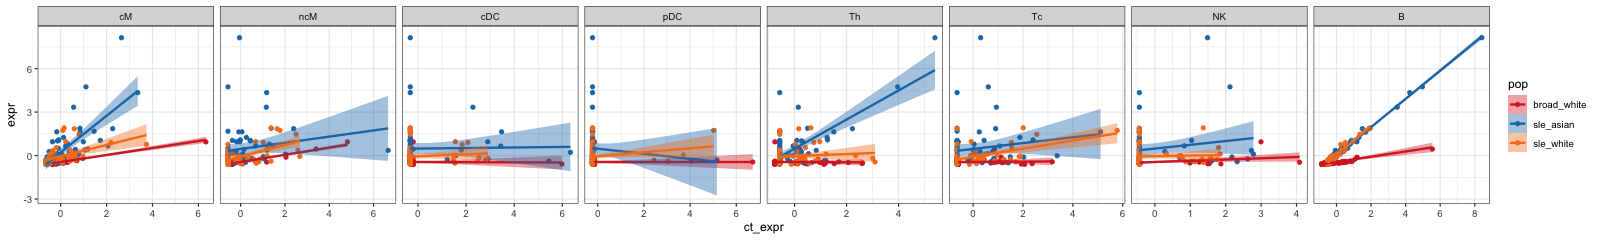

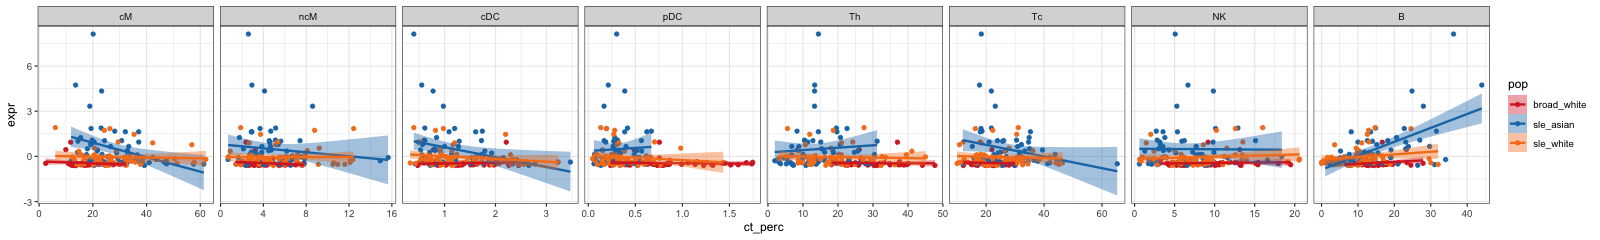

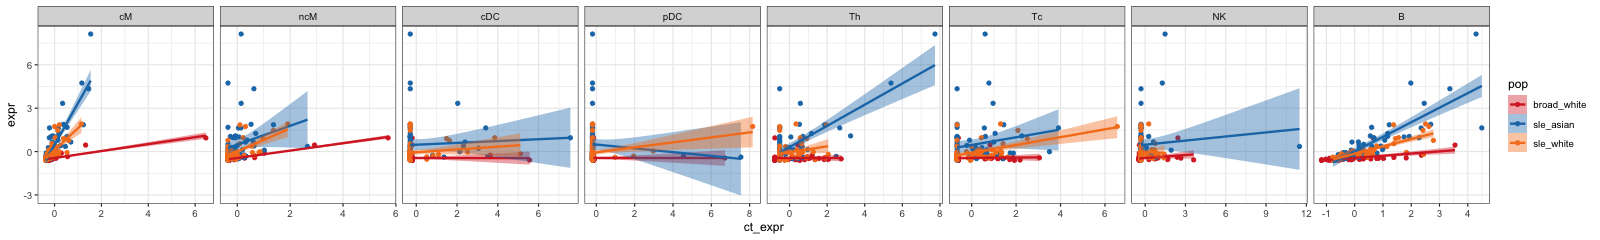

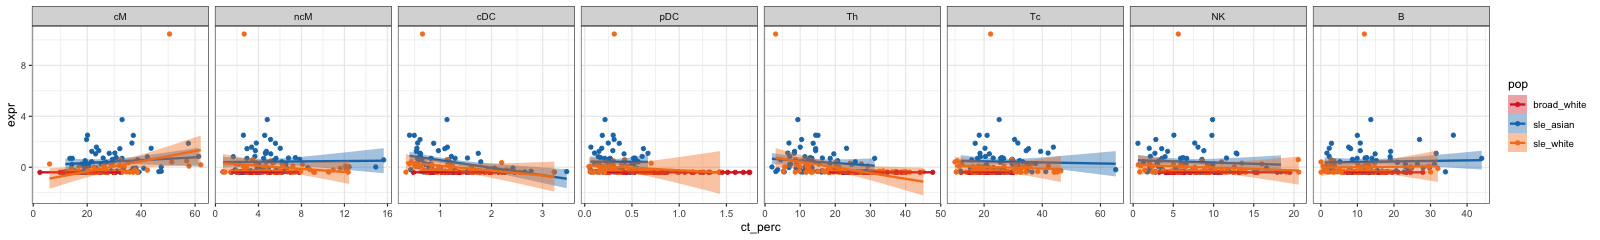

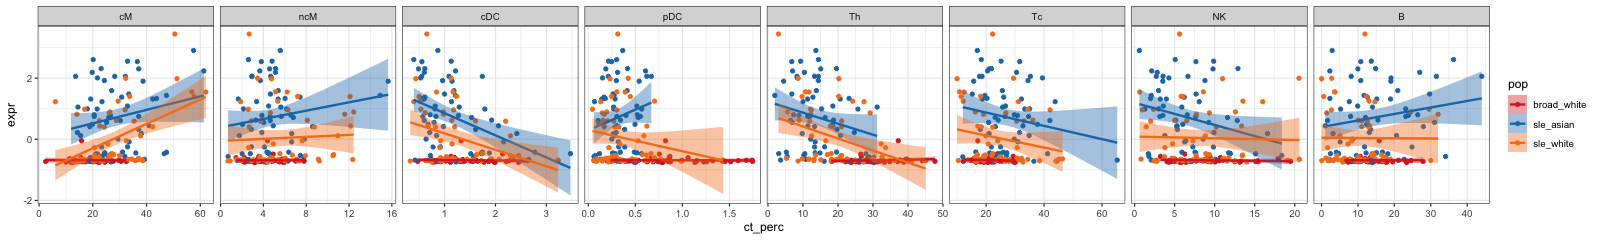

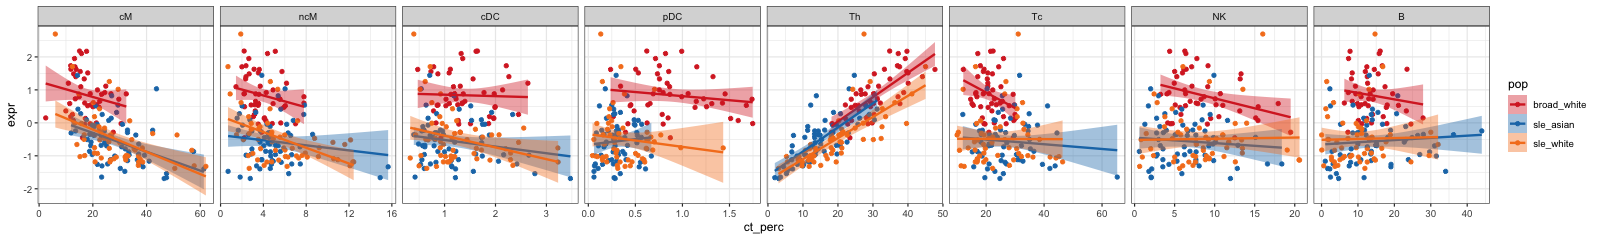

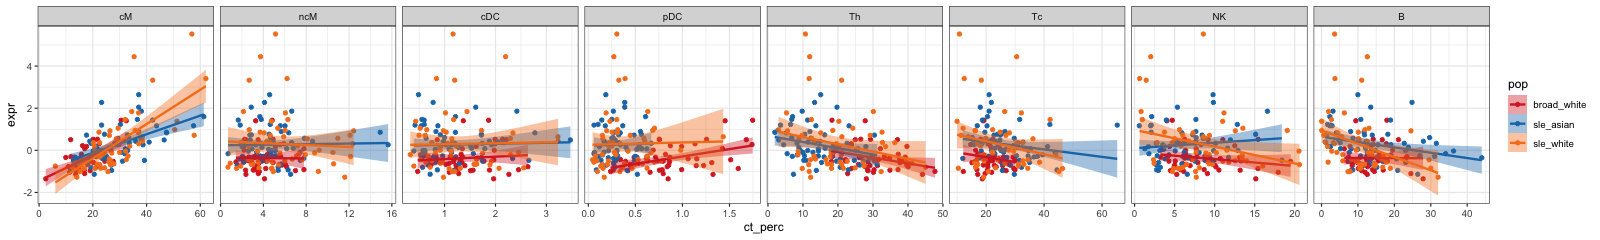

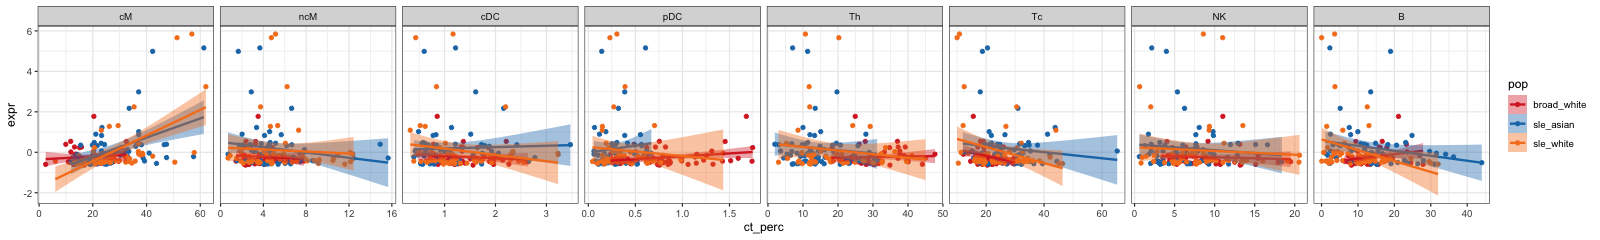

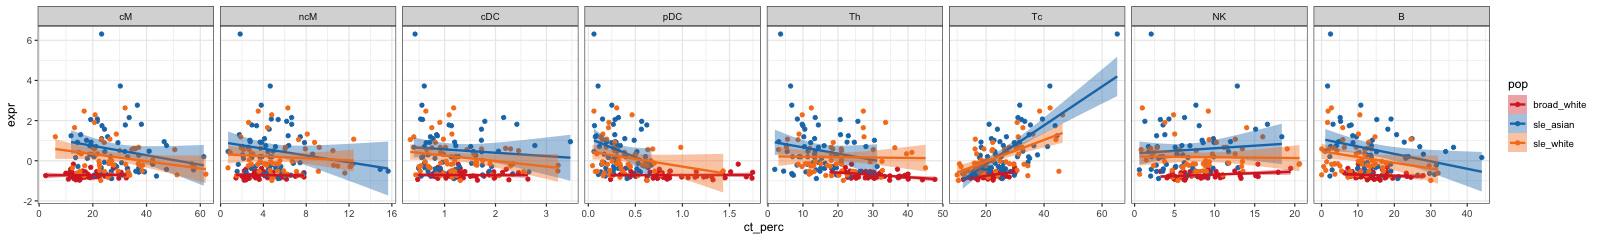

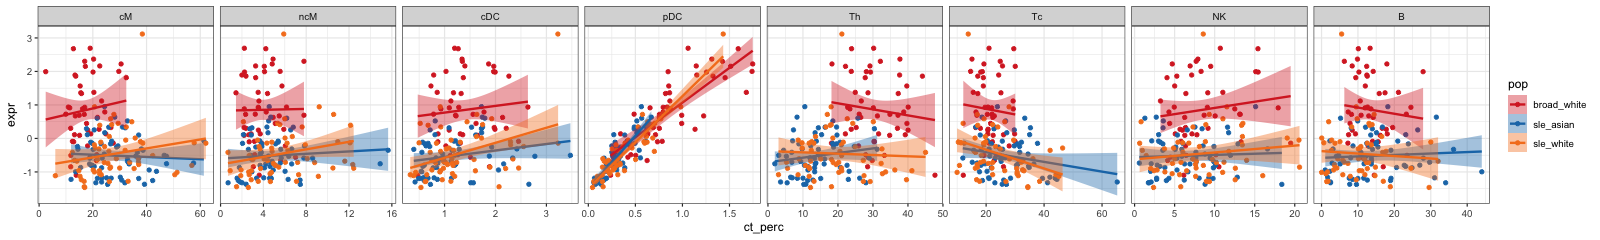

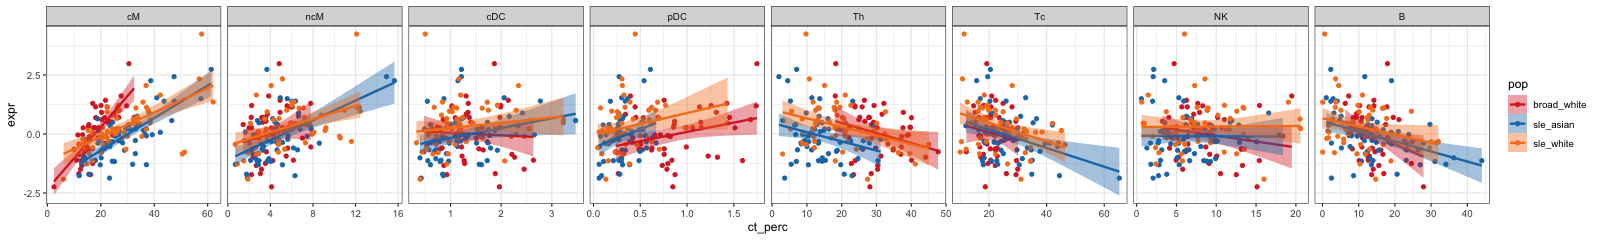

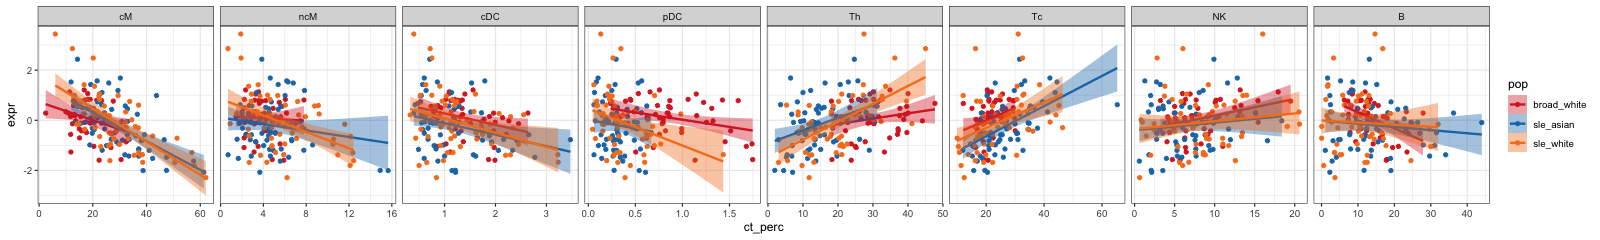

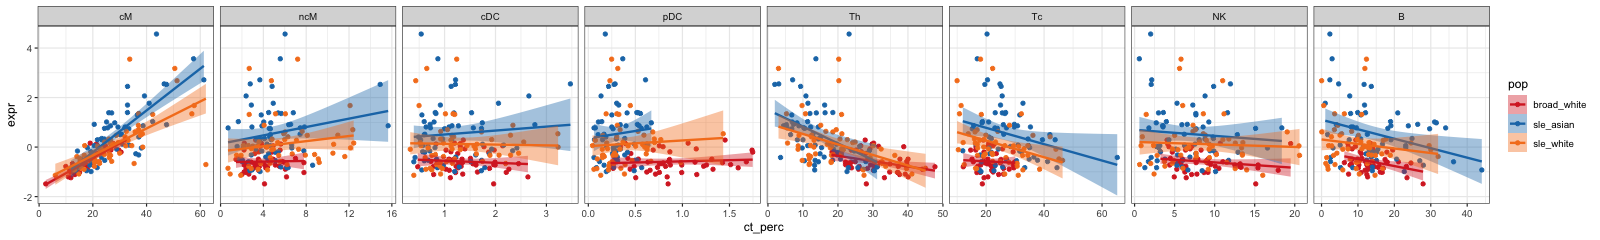

In [114]:
source("helper_functions.R")
options(repr.plot.width = 20, repr.plot.height = 3)
props_all = rbind(data.frame(props_broad_healthy,pop="broad_white"),
                  data.frame(props[samples_asian,],pop="sle_asian"),
                  data.frame(props[samples_white,],pop="sle_white"))

exprs_all_pbmc_counts = list(exprs_broad_healthy_std_pbmc_counts, exprs_pbmc_counts_std[,samples_asian,], exprs_pbmc_counts_std[,samples_white,])
exprs_all_ct_counts = list(exprs_broad_healthy_std_ct_counts, exprs_ct_counts_std[,samples_asian,], exprs_ct_counts_std[,samples_white,])

##expr_all = cbind(pbmc_broad_healthy_expr, pbmc_expr[,c(samples_asian,samples_white)])
expr_all = pbmc_expr_std[,c(broad_healthy_indices, samples_asian, samples_white)]

il6 <- plot_single_gene_expr(expr_all, exprs_all_pbmc_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_all.png",width=11, height=1.75)

il6 <- plot_single_gene_prop(expr_all, props_all, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_prop.png",width=11, height=1.75)

il6 <- plot_single_gene_expr(expr_all, exprs_all_ct_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6_expr.png",width=11, height=1.75)

## ifi27 asian vs cau differences
ifi27 <- plot_single_gene_prop(expr_all, props_all, grep("^IFI27$",expr_gene_names)[1])
ggsave(ifi27, file="IFI27.png",width=11, height=2)
ifi44l <- plot_single_gene_prop(expr_all, props_all, grep("^IFI44L$",expr_gene_names)[1])
ggsave(ifi44l, file="IFI44L.png",width=11, height=2)
ccr7 <- plot_single_gene_prop(expr_all, props_all, grep("^CCR7$",expr_gene_names)[1])
ggsave(ccr7, file="CCR7.png",width=11, height=2)
nlrp3 <- plot_single_gene_prop(expr_all, props_all, grep("^NLRP3$",expr_gene_names)[1])
ggsave(nlrp3, file="NLRP3.png", width=11, height=2)
thbs1 <- plot_single_gene_prop(expr_all, props_all, grep("^THBS1$",expr_gene_names)[1])
ggsave(thbs1, file="THBS1.png", width=11, height=2)
ifng <- plot_single_gene_prop(expr_all, props_all, grep("^IFNG$",expr_gene_names)[1])
ggsave(ifng, file="IFNG.png",width=11, height=2)
lilra4 <- plot_single_gene_prop(expr_all, props_all, grep("^LILRA4$",expr_gene_names)[1])
ggsave(lilra4, file="LILRA4.png",width=11, height=2)
cd4 <- plot_single_gene_prop(expr_all, props_all, grep("^CD4$",expr_gene_names)[1])
ggsave(cd4, file="CD4.png",width=11, height=2)
lck <- plot_single_gene_prop(expr_all, props_all, grep("^LCK$",expr_gene_names)[1])
ggsave(lck, file="LCK.png",width=11, height=2)
cd14 <- plot_single_gene_prop(expr_all, props_all, grep("^CD14$",expr_gene_names)[1])
ggsave(cd14, file="CD14.png",width=11, height=2)


## Processing UCSF healthy

In [78]:
output_ucsf_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_ucsf_healthy_expr, props_ucsf_healthy, exprs_ucsf_healthy_pbmc_counts);
# output_ucsf_healthy_prop_noint <- model_prop(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy);
# output_ucsf_healthy_expr_noint <- model_expr(pbmc_ucsf_healthy_expr_std, exprs_ucsf_healthy_std);
output_ucsf_healthy_prop_noint <- output_ucsf_healthy_prop_expr_noint[[1]]
output_ucsf_healthy_expr_noint <- output_ucsf_healthy_prop_expr_noint[[4]]
output_ucsf_healthy_expr_pbmc_count_noint <- output_ucsf_healthy_prop_expr_noint[[7]]

## Processing Broad healthy

In [79]:
output_broad_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_broad_healthy_expr, props_broad_healthy, exprs_broad_healthy_pbmc_counts);
# output_broad_healthy_prop_noint <- model_prop(pbmc_broad_healthy_expr_std, props_broad_healthy);
# output_broad_healthy_expr_noint <- model_expr(pbmc_broad_healthy_expr_std, exprs_broad_healthy_std);
output_broad_healthy_prop_noint <- output_broad_healthy_prop_expr_noint[[1]];
output_broad_healthy_expr_noint <- output_broad_healthy_prop_expr_noint[[4]];
output_broad_healthy_expr_pbmc_count_noint <- output_broad_healthy_prop_expr_noint[[7]];


## matching ucsf and broad

In [80]:
# a <- match(sapply(rownames(props_ucsf_healthy),function(x){strsplit(x,"_")[[1]][[1]]}), sapply(rownames(props_broad_healthy), function(x) {strsplit(x,"_")[[1]][[1]]}))

# props_ucsf_healthy_matched <- props_ucsf_healthy[!is.na(a),]
# props_broad_healthy_matched <- props_broad_healthy[na.omit(a),]

# pbmc_ucsf_healthy_expr_matched <- pbmc_ucsf_healthy_expr[,!is.na(a)]
# pbmc_broad_healthy_expr_matched <- pbmc_broad_healthy_expr[,na.omit(a)]

# pbmc_ucsf_healthy_expr_std_matched <- pbmc_ucsf_healthy_expr_std[,!is.na(a)]
# pbmc_broad_healthy_expr_std_matched <- pbmc_broad_healthy_expr_std[,na.omit(a)]

# exprs_ucsf_healthy_std_matched <- exprs_ucsf_healthy_std[,!is.na(a),]
# exprs_broad_healthy_std_matched <- exprs_broad_healthy_std[,na.omit(a),]

# exprs_ucsf_healthy_matched <- exprs_ucsf_healthy[,!is.na(a),]
# exprs_broad_healthy_matched <- exprs_broad_healthy[,na.omit(a),]


# output_ucsf_healthy_prop_expr_noint_matched <- model_prop_expr_noah(pbmc_ucsf_healthy_expr_matched, props_ucsf_healthy_matched,exprs_ucsf_healthy_matched);
# # output_ucsf_healthy_prop_noint_matched <- model_prop(pbmc_ucsf_healthy_expr_std_matched, props_ucsf_healthy_matched);
# # output_ucsf_healthy_expr_noint_matched <- model_expr(pbmc_ucsf_healthy_expr_std_matched, exprs_ucsf_healthy_std_matched);
# output_ucsf_healthy_prop_noint_matched <- output_ucsf_healthy_prop_expr_noint_matched[[1]]
# output_ucsf_healthy_expr_noint_matched <- output_ucsf_healthy_prop_expr_noint_matched[[2]]

# output_broad_healthy_prop_expr_noint_matched <- model_prop_expr_noah(pbmc_broad_healthy_expr_std_matched, props_broad_healthy_matched, exprs_broad_healthy_std_matched);
# # output_broad_healthy_prop_noint_matched <- model_prop(pbmc_broad_healthy_expr_std_matched, props_broad_healthy_matched);
# # output_broad_healthy_expr_noint_matched <- model_expr(pbmc_broad_healthy_expr_std_matched, exprs_broad_healthy_std_matched);
# output_broad_healthy_prop_noint_matched <- output_broad_healthy_prop_expr_noint_matched[[1]];
# output_broad_healthy_expr_noint_matched <- output_broad_healthy_prop_expr_noint_matched[[2]];


## Summarize and plotting results

Warning message:
“Removed 6 rows containing missing values (geom_point).”

cor        prop_mean expr_mean sum_mean
all           -0.9450064 22.114391 69.70384  91.81823
sle           -0.9156696 16.694935 71.30701  88.00194
sle_asian     -0.9057027 14.203734 65.73881  79.94255
sle_white     -0.9487126 17.171157 61.98123  79.15239
ucsf_healthy  -0.9539941  6.765927 29.62109  36.38702
broad_healthy -0.9528761 15.192688 61.40683  76.59952

cM        Th         B        NK        ncM      Tc       
all_prop            7.933107  2.6653767 2.997430  2.266788 2.168169  1.464992
all_expr           17.925440 14.6084490 8.994400  5.328525 4.695182 16.019310
sle_prop            6.543942  1.9212174 3.798470  2.521682 2.352308  2.192517
sle_expr           21.806084 11.0013610 8.855245  5.312427 5.479726 17.649508
sle_asian_prop      5.827682  3.3070650 4.008064  2.361105 2.843829  2.955388
sle_asian_expr     20.826012  9.1759156 9.917065  4.731743 4.836103 17.658094
sle_white_prop      8.469766  2.2328712 3.927594  5.130725 3.228518  1.758043
sle_white_expr     20.092342 11.6061374 6.467115  5.405833 5.536166 15.383001
ucsf_healthy_prop   7.582050  0.4162834 5.368257 10.098553 5.470703  3.781260
ucsf_healthy_expr   9.676517 16.5690306 6.397386  4.543909 3.228511 12.164511
broad_healthy_prop  8.944684 -0.1911167 4.532783  5.030233 3.016115  2.169084
broad_healthy_expr 12.911629 18.6632348 9.327278  5.510166 3.976712 13.766273
                   cDC      pDC       total.r2 adj.r2    adj.prop_expr.r2
all_prop           1.082355 4.8860916 25.46431 22.114391  80.79842       
all_expr           2.405930 1.0296615 71.00690 69.703837  91.81823       
sle_prop           1.875800 1.1850703 22.39101 16.694935  76.79934       
sle_expr           2.393059 0.7715108 73.26892 71.307007  88.00194       
sle_asian_prop     2.298349 1.8542220 25.45570 14.203734  76.12208       
sle_asian_expr     2.284730 0.8024206 70.23208 65.738813  79.94255       
sle_white_prop     2.314684 2.1567864 29.21899 17.171157  79.56864       
sle_white_expr     2.227852 0.7927843 67.51123 61.981229  79.15239       
ucsf_healthy_prop  5.005248 4.5613147 42.28367  6.765927 135.47549       
ucsf_healthy_expr  2.465670 1.3865718 56.43211 29.621095  36.38702       
broad_healthy_prop 1.894965 4.5450388 29.94179 15.192688  84.58812       
broad_healthy_expr 2.408298 1.5550964 68.11869 61.406831  76.59952

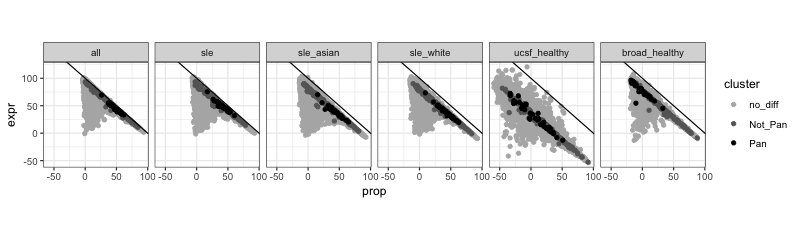

In [81]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down")
# output_sle_down_noint_df$cluster <- "no_diff";
# output_sle_down_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_down_noint_df))] <- cuttree_out[,"cluster"];

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"adj r2"], expr=output_sle_asian_expr_noint[,"adj r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"adj r2"], expr=output_sle_white_expr_noint[,"adj r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"adj r2"], expr=output_ucsf_healthy_expr_noint[,"adj r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"adj r2"], expr=output_broad_healthy_expr_noint[,"adj r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

# output_ucsf_healthy_noint_matched_df <- data.frame(prop=output_ucsf_healthy_prop_noint_matched[,"adj r2"], expr=output_ucsf_healthy_expr_noint_matched[,"adj r2"], type="ucsf_healthy_matched")
# output_ucsf_healthy_noint_matched_df$cluster <- "no_diff";
# output_ucsf_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

# output_broad_healthy_noint_matched_df <- data.frame(prop=output_broad_healthy_prop_noint_matched[,"adj r2"], expr=output_broad_healthy_expr_noint_matched[,"adj r2"], type="broad_healthy_matched")
# output_broad_healthy_noint_matched_df$cluster <- "no_diff";
# output_broad_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_matched_df))] <- as.character(cuttree_out[,"cluster"]);

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df)
# ,
#             output_ucsf_healthy_noint_matched_df, output_broad_healthy_noint_matched_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "Pan")] <- "Not_Pan";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","Not_Pan","Pan"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

# ggplot(aes(prop, expr,color=(cluster=="Pan")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Pan'),
#              aes(x = prop, y = expr, color = (cluster=="Pan")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye1'),
#              aes(x = prop, y = expr, color = (cluster=="Mye1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mye2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mye2'),
#              aes(x = prop, y = expr, color = (cluster=="Mye2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Mono")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Mono'),
#              aes(x = prop, y = expr, color = (cluster=="Mono")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T1")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T1'),
#              aes(x = prop, y = expr, color = (cluster=="T1")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T2")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T2'),
#              aes(x = prop, y = expr, color = (cluster=="T2")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="T3")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'T3'),
#              aes(x = prop, y = expr, color = (cluster=="T3")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="Lymph")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'Lymph'),
#              aes(x = prop, y = expr, color = (cluster=="Lymph")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]),
                        cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]),
                        ##cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]),
                        cor(output_sle_asian_prop_noint[,"adj r2"], output_sle_asian_expr_noint[,"adj r2"]),
                        cor(output_sle_white_prop_noint[,"adj r2"], output_sle_white_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_ucsf_healthy_prop_noint[,"adj r2"], output_ucsf_healthy_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_broad_healthy_prop_noint[,"adj r2"], output_broad_healthy_expr_noint[,"adj r2"], use='complete.obs')),
#                         cor(output_ucsf_healthy_prop_noint_matched[,"adj r2"], output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
#                         cor(output_broad_healthy_prop_noint_matched[,"adj r2"], output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]),
                              mean(output_sle_asian_prop_noint[,"adj r2"]), mean(output_sle_white_prop_noint[,"adj r2"], na.rm=T),
                              mean(output_ucsf_healthy_prop_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_prop_noint[,"adj r2"], na.rm=T)),
#                               mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]), mean(output_broad_healthy_prop_noint_matched[,"adj r2"])),
                  expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]),
                              mean(output_sle_asian_expr_noint[,"adj r2"]), mean(output_sle_white_expr_noint[,"adj r2"],na.rm=T),
                              mean(output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)),
#                               mean(output_ucsf_healthy_expr_noint_matched[,"adj r2"]), mean(output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), 
                               mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), 
                               mean(output_sle_asian_prop_noint[,"adj r2"]+output_sle_asian_expr_noint[,"adj r2"]), 
                               mean(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"],na.rm=T), 
                               mean(output_ucsf_healthy_prop_noint[,"adj r2"]+output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T),
                               mean(output_broad_healthy_prop_noint[,"adj r2"]+output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)))
#                                mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]+output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
#                                mean(output_broad_healthy_prop_noint_matched[,"adj r2"]+output_broad_healthy_expr_noint_matched[,"adj r2"])))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy")##, "ucsf_healthy_matched", "broad_healthy_matched")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))))
#             data.frame(t(apply(output_ucsf_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_ucsf_healthy_expr_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_prop_noint_matched,2,mean,na.rm=T))),
#             data.frame(t(apply(output_broad_healthy_expr_noint_matched,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr")
##                  "ucsf_healthy_matched_prop", "ucsf_healthy_matched_expr","broad_healthy_matched_prop", "broad_healthy_matched_expr")

df3

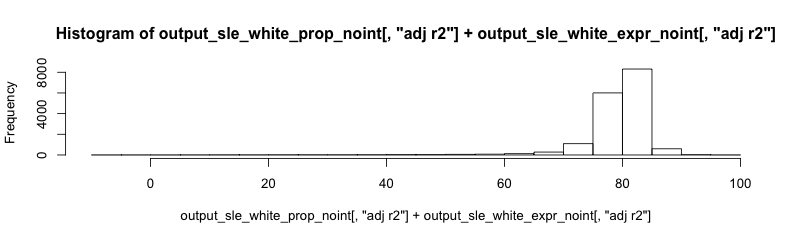

In [82]:
hist(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"])

In [83]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);


In [84]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);

df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster == "Pan")] <- "pan";
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster != "Pan")] <- "no_pan";
df_all_ifn$cluster2 <- factor(df_all_ifn$cluster2, levels=c("no_diff","no_pan","pan"));

##df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff")] <- "diff";
##df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","diff"));

df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]

##ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

sle_asian_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))
ggsave("sle_asian_diff_no_diff_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_asian_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_asian_cluster_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("sle_white_diff_no_diff_histogram.png", sle_white_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_white_cluster_histogram.png", sle_white_p, dpi=300, height=3, width=3)

broad_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("broad_white_diff_no_diff_histogram.png", broad_white_p, dpi=300, height=3, width=3)


broad_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("broad_white_cluster_histogram.png", broad_white_p, dpi=300, height=3, width=3)

# sle_asian_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_asian_plot.png", ggMarginal(sle_asian_p, type="histogram"),dpi = 300, height=3, width=3)

# sle_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_white_plot.png", ggMarginal(sle_white_p, type="histogram"),dpi = 300, height=3, width=3)

# broad_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("broad_white_plot.png", ggMarginal(broad_white_p, type="histogram"), dpi = 300, height=3, width=3)


Warning message:
“Removed 4163 rows containing non-finite values (stat_density).”Warning message:
“Removed 4163 rows containing non-finite values (stat_density).”Warning message:
“Removed 3502 rows containing non-finite values (stat_density).”Warning message:
“Removed 3502 rows containing non-finite values (stat_density).”Warning message:
“Removed 3917 rows containing non-finite values (stat_density).”Warning message:
“Removed 3917 rows containing non-finite values (stat_density).”

In [85]:
# mean(df_all_ifn$prop[intersect(grep("healthy",df_all_ifn$type), which(df_all_ifn$cluster=="1"))])

In [86]:
# colMeans(output_prop_noint[match(pbmc_deseq_sig_genes,rownames(output_prop_noint)),],na.rm=T)


In [87]:
# output_prop_noint[match("IFI6",rownames(output_prop_noint)),]
# output_expr_noint[match("IFI6",rownames(output_expr_noint)),]

In [88]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    print(i);
    
        rst <- rbind(rst,
                     c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_prop_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_prop_noint)),],na.rm=T),cluster=i))
    
     rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster=i))
    
       rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_prop_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint),cluster="all"))

# rst_sle <- rbind(rst_sle,
#                  c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                  rownames(output_sle_prop_noint)),],na.rm=T), cluster="no_diff"))
                 
# rst_ctrl <- rbind(rst_ctrl,
#                   c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                                   rownames(output_broad_healthy_prop_noint)),],na.rm=T), cluster="no_diff"))
rst
rst_sle
rst_ctrl

[1] "Misc"
[1] "Mono"
[1] "ncM"
[1] "no_diff"
[1] "Pan"
[1] "pDC"
[1] "T4"
[1] "T8_1"
[1] "T8_2"


cM                Th                B                  
 [1,] 16.6503884287352  0.858693428904484 2.1610161505952    
 [2,] 47.3585396745099  1.94272646051652  -0.505538443787784 
 [3,] 19.662785581126   3.33501870604279  -0.0732948646151442
 [4,] 7.69819457617057  2.62326827465299  3.02503910871065   
 [5,] 32.0681425916255  2.49752574687761  1.131171789279     
 [6,] 0.241089513583306 1.92994513980884  0.00913620866385841
 [7,] 1.24398651288589  44.5791237882737  0.185201801775816  
 [8,] 5.04365258131863  -0.94242142257084 2.56806621293309   
 [9,] 0.269214688157038 6.67431770564553  1.622314893929     
[10,] 28.9533301765195  6.43328216879196  0.526943041247266  
[11,] 28.1212912437172  7.48461436368689  0.365539471567556  
[12,] 7.93310706114964  2.66537667840565  2.99743006560887   
      NK                  ncM               Tc                
 [1,] 0.386896572743287   0.455844725956536 0.599920600894664 
 [2,] 0.00155728437007202 2.31848002457721  0.0927452532898196
 [3,] 0.136737169725399   14.0059806915143  0.46320693739803  
 [4,] 2.28157836195042    2.1685000713988   1.4542852063604   
 [5,] 0.423994234379781   2.76857995700052  0.274869510541288 
 [6,] 1.1316220191604     0.075869461627783 -0.995109226495199
 [7,] 0.501971870859965   0.500105082102192 0.268821845112993 
 [8,] 0.0576374046249819  0.393448438763144 12.0568666363738  
 [9,] 12.5239260801948    0.244469450469551 20.3813722473998  
[10,] 0.943299340724479   2.13853640242239  2.4230631012561   
[11,] 1.08201782803573    1.97023709674741  2.99689563576211  
[12,] 2.26678765647657    2.16816891190537  1.46499217275957  
      cDC               pDC              total r2         adj r2          
 [1,] 2.06903530370296  2.27356617694113 25.4553613884734 22.1050405520003
 [2,] 1.38006663691668  2.83857224316751 55.4271491335599 53.4238749373154
 [3,] 3.01927939709971  2.47274744997939 43.0224610682705 40.4616728016759
 [4,] 1.05529421110321  4.89411357846169 25.2002733888087 21.8384879231372
 [5,] 10.0384392900527  2.69635336028843 51.8990764800448 49.737237220721 
 [6,] 2.48630310628663  67.9305931588703 72.8094493815059 71.5874021626972
 [7,] 0.698942004510997 4.74527044407565 52.7234233495972 50.5986333877813
 [8,] 3.83111725046757  5.45456734515512 28.4629344470655 25.2477854334504
 [9,] 1.9385478396017   1.77385900944714 45.4280219148445 42.975348742478 
[10,] 3.50382239803647  4.16827945671702 49.0905560857152 46.8024911906912
[11,] 1.75827405016913  4.56146519480411 48.3403348844902 46.0185521826695
[12,] 1.08235542829556  4.88609163494519 25.4643096095464 22.1143909403125
      adj prop_expr r2 cluster  
 [1,] 82.2571543692823 Misc     
 [2,] 91.6131388367167 Mono     
 [3,] 114.179113601934 ncM      
 [4,] 80.7068295170912 no_diff  
 [5,] 90.0805988441247 Pan      
 [6,] 95.074986128225  pDC      
 [7,] 86.4705162623837 T4       
 [8,] 70.686283383167  T8_1     
 [9,] 90.973201178985  T8_2     
[10,] 88.9939481221572 diff     
[11,] 88.7036784087549 cell_type
[12,] 80.7984190350993 all

cM                 Th                   B                  
 [1,] 14.9924375670668   0.97469781985923     3.60933250715804   
 [2,] 40.8617331196421   1.71664513929339     -0.618270675265446 
 [3,] 15.6849372208929   3.28087552605856     -0.0432420044202609
 [4,] 6.35034769777048   1.87825084010701     3.82931801563155   
 [5,] 24.8199182657601   2.25588733845343     2.26507693096136   
 [6,] 1.04972646687466   -0.00316241562302026 -0.172745686737896 
 [7,] 0.095853147290329  36.4582929109617     1.40896460689614   
 [8,] -0.521705448826742 4.15180402682422     3.33495209832828   
 [9,] 0.0400137854191366 4.91584666821689     1.94893275237553   
[10,] 23.86701224594     5.76591113730071     1.03811862543752   
[11,] 23.612468857084    6.70352023425307     0.710369489030466  
[12,] 6.54394247293096   1.92121739455953     3.79846958459112   
      NK                  ncM               Tc                cDC             
 [1,] 0.712375518419341   1.44952147432585  0.517683781448362 2.55054988637111
 [2,] 0.251886142219041   2.38305004203417  -1.02408198070341 1.56447708481061
 [3,] 0.138561039707252   12.4755000885667  -0.24422447597806 3.76651259182134
 [4,] 2.53737611002141    2.35593774845995  2.19792237902543  1.84228500626498
 [5,] 0.318442401312532   1.68431796097084  -1.11639402878861 14.9279036049837
 [6,] 0.61136509100664    0.623029671916331 -1.75880870255187 5.21996064243777
 [7,] 0.943950112392219   0.203190986806105 0.465809996546319 1.2707399111976 
 [8,] -0.0266221897338148 1.38050346449588  11.3088959290233  4.66058532911716
 [9,] 13.1596425928559    0.267498599726325 22.5661997053228  2.40922104243795
[10,] 1.11739659995846    2.02751250097538  1.70882725349805  4.8747810111225 
[11,] 1.3308158721995     2.11918775481221  2.4635096508212   2.18935785248836
[12,] 2.52168244795309    2.3523079814019   2.19251688298489  1.87580025573619
      pDC               total r2         adj r2           adj prop_expr r2
 [1,] 0.503241396231583 25.3098399508803 19.8279933417707 82.5023052233066
 [2,] 0.426226032587001 45.5616649046174 41.5661907691765 89.7801335100681
 [3,] 0.969889559324048 36.0288095459725 31.3336763016402 113.475551816033
 [4,] 1.18301793648453  22.1744557337653 16.4624891821151 76.673036231592 
 [5,] 0.034043089380714 45.189195563034  41.1663842282108 98.6937844735304
 [6,] 60.9986096810322  66.5679747483549 64.1142481243809 91.9595225024923
 [7,] 0.415766312926952 41.2625679850174 36.9515638004315 75.3560303359804
 [8,] 0.504212830385183 24.7926260396135 19.2728187764659 62.6306785384848
 [9,] 0.65809413765063  45.9654492840051 41.999610699345  90.0897928989864
[10,] 1.36872233344466  41.7682817076773 37.4943941265894 88.1012712495196
[11,] 1.72524624110558  40.8544759517943 36.513520058348  85.2717642924209
[12,] 1.18507034782557  22.3910073679832 16.6949345142572 76.7993414755323
      cluster  
 [1,] Misc     
 [2,] Mono     
 [3,] ncM      
 [4,] no_diff  
 [5,] Pan      
 [6,] pDC      
 [7,] T4       
 [8,] T8_1     
 [9,] T8_2     
[10,] diff     
[11,] cell_type
[12,] all

cM               Th                 B                 NK               
 [1,] 6.53796981754694 0.600008068334958  2.32072463024669  1.55713657598634 
 [2,] 40.4946698614217 -0.105782111842853 0.602788830771307 1.34104823169083 
 [3,] 2.18343822394987 1.01267068643159   2.37738869812206  0.572653050922952
 [4,] 8.83401479012408 -0.234329625598415 4.56718233217898  5.05180424957619 
 [5,] 4.01580921192548 0.49425920782759   0.959410079915436 1.26049790563221 
 [6,] 2.04555948496286 -0.958235917298379 0.437822357621125 1.32922162196894 
 [7,] 0.27443616124275 32.0807218195495   0.983708137591923 1.22237792888777 
 [8,] 5.15245680484581 0.759749248472796  5.61821696394325  6.03384271139611 
 [9,] 1.19163574483502 3.21388442975255   2.61914083780007  24.7458373242601 
[10,] 18.8445222322873 3.67445809238402   1.45563325634747  3.10061892969281 
[11,] 22.8056168062195 4.52396327387512   1.58818602265465  3.59215810735283 
[12,] NaN              NaN                NaN               NaN              
      ncM               Tc                cDC               pDC             
 [1,] 1.63822598026488  1.83309297424514  2.23179820778643  2.32714415693308
 [2,] 1.53287089983855  0.660909715851701 1.22053133097391  4.68133243960765
 [3,] 21.7605611825421  1.20324254854696  1.55378703547559  6.42184251930134
 [4,] 3.02463075610592  2.16702345318077  1.89966180248216  4.54643426159884
 [5,] 1.75441357945321  2.44580395622588  1.76298828762639  2.09653168598117
 [6,] 0.173215842942985 0.893933543945193 0.125479809835223 62.2203129115821
 [7,] 2.79683081716142  0.376453967796205 2.1150555442231   1.15606778541143
 [8,] 1.40020738889181  5.91254288264382  1.13656621573927  4.84291085612163
 [9,] 0.094108233236072 13.7987499445161  0.979995792222738 1.66249939854302
[10,] 2.25432249485387  2.3534082209516   1.47477222032598  4.42020919273194
[11,] 2.38785980787185  2.32872716837833  1.39778299686903  5.0409175678229 
[12,] NaN               NaN               NaN               NaN             
      total r2         adj r2           adj prop_expr r2 cluster  
 [1,] 19.0461004113445 2.00317418215382 64.9949500780334 Misc     
 [2,] 50.4283691983128 39.9922363979576 83.7493523175488 Mono     
 [3,] 37.0855839452925 23.8404437232488 99.068981884561  ncM      
 [4,] 29.8564220196485 15.0893529711535 84.7745131598403 no_diff  
 [5,] 14.7897139145874 -3.1492936823416 32.9305729466677 Pan      
 [6,] 66.26730965556   59.1656906356779 96.3280383908735 pDC      
 [7,] 41.0056521618641 28.5857894590987 76.3289201421469 T4       
 [8,] 30.8564930720545 16.2999652977502 52.6470218021733 T8_1     
 [9,] 48.3058517051656 37.4228731167794 67.7502028038545 T8_2     
[10,] 37.577944639575  24.4364593005381 67.9144532071444 diff     
[11,] 43.6652117510442 31.8052563302114 77.2594623178197 cell_type
[12,] NaN              NaN              NaN              all

In [89]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    print(i);
    
        rst <- rbind(rst,
                     c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_expr_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_expr_noint)),],na.rm=T),cluster=i))
    
     rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster=i))
    
       rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_expr_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint),cluster="all"))

# rst_sle <- rbind(rst_sle,
#                  c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                  rownames(output_sle_expr_noint)),],na.rm=T), cluster="no_diff"))
                 
# rst_ctrl <- rbind(rst_ctrl,
#                   c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="no_diff")],
#                                                                                   rownames(output_broad_healthy_expr_noint)),],na.rm=T), cluster="no_diff"))
rst
rst_sle
rst_ctrl

[1] "Misc"
[1] "Mono"
[1] "ncM"
[1] "no_diff"
[1] "Pan"
[1] "pDC"
[1] "T4"
[1] "T8_1"
[1] "T8_2"


cM                Th                 B                 
 [1,] 47.2874559801981  4.63145055351877   5.04542383862061  
 [2,] 33.0596325533059  0.887039767453331  1.63663939974689  
 [3,] 12.6431804221345  0.0649135918811989 0.0102522355513437
 [4,] 17.8534632990215  14.7112745397147   9.06517142869944  
 [5,] 24.8907226031038  3.71688654610682   2.89640339234362  
 [6,] 0.795811176986257 0.448308058804774  2.52762941913633  
 [7,] 1.35199919668534  27.2720718350331   1.29473698814416  
 [8,] 12.0519527381529  11.143789026627    9.05967620297415  
 [9,] 2.9625042677455   2.18948864259647   0.508990617450748 
[10,] 24.3659868292152  5.40751197421221   2.66170281247352  
[11,] 24.2258176841354  5.8591173967883    2.59900882196027  
[12,] 17.9254399316212  14.6084490379154   8.99440007473554  
      NK                   ncM                Tc               
 [1,] 1.52225140563935     5.42058347632328   5.77706730314819 
 [2,] 0.761933333614622    4.00722666026137   1.79532428636637 
 [3,] 0.000740587692255627 43.5153442051617   0.151436486350419
 [4,] 5.36127995330681     4.69100070757276   16.1163226434001 
 [5,] 1.77453496481933     6.11502458723308   4.98619300882524 
 [6,] 0.0816139309108984   0.0794090514800657 0.767413260342481
 [7,] 2.1323491270826      0.457599062356096  12.0908611391941 
 [8,] 4.53928982091813     2.49857511503484   24.7778082243032 
 [9,] 16.4519517811047     0.445037834135908  28.605627902336  
[10,] 2.39757446192178     5.06933985403768   7.33851080268559 
[11,] 2.56400282073681     4.79001311023891   7.96686966542911 
[12,] 5.32852497894119     4.69518212474798   16.0193099669838 
      cDC               pDC                total r2         adj r2          
 [1,] 3.29035041603746  0.189951621564273  73.16453459505   71.9584462622432
 [2,] 1.56203872729104  0.186291900855263  43.8961266288948 41.3746042301935
 [3,] 0.397000141963033 0.0169322994338722 56.7997999701684 54.8582179463557
 [4,] 2.41574188267013  1.03606407244822   71.2503185268337 69.9581980111858
 [5,] 1.23339870820734  0.320846018443027  45.9340098290823 43.5040776865691
 [6,] 8.61906050527823  13.9077473181335   27.2269927210726 23.9562957647163
 [7,] 0.220014017525388 0.100938277305701  44.9205696433264 42.4450896272962
 [8,] 1.98545340630736  0.520853215874375  66.5773977501919 65.0752583232343
 [9,] 0.366997062245134 0.264149337476819  51.7947474450913 49.6282192403763
[10,] 1.52793572071476  0.456750005259893  49.2253124605206 46.94330403178  
[11,] 1.6066134158366   0.493053125026043  50.1044960401514 47.8620014801582
[12,] 2.40592981863036  1.02966147358151   71.006897407157  69.7038366164674
      adj prop_expr r2 cluster  
 [1,] 94.0634868142436 Misc     
 [2,] 94.7984791675089 Mono     
 [3,] 95.3198907480316 ncM      
 [4,] 91.796685934323  no_diff  
 [5,] 93.2413149072901 Pan      
 [6,] 95.5436979274134 pDC      
 [7,] 93.0437230150775 T4       
 [8,] 90.3230437566847 T8_1     
 [9,] 92.6035679828543 T8_2     
[10,] 93.7457952224712 diff     
[11,] 93.8805536628277 cell_type
[12,] 91.81822755678   all

cM               Th                 B                   
 [1,] 46.9377869348148 3.75750426987946   6.02543688197452    
 [2,] 40.9713799451323 0.845247774000096  1.92300622215586    
 [3,] 14.0359827100682 0.0681930410469339 -0.00301592569675853
 [4,] 21.7300244782014 11.0630392897792   8.91932662864647    
 [5,] 28.0128565778445 4.16635851675217   3.33054977252926    
 [6,] 2.99041899209461 1.18731822677895   3.41877554739397    
 [7,] 2.35929254542827 28.7495298614312   2.37016754381259    
 [8,] 13.6444743240685 10.4901934026391   9.63917812213731    
 [9,] 2.95160043970246 1.45428618801012   0.508898743703387   
[10,] 28.6119977568659 5.48232185585839   3.12116317371708    
[11,] 28.7720423183853 5.83384630945526   3.06523113704808    
[12,] 21.8060842820459 11.001361009997    8.85524512800952    
      NK                   ncM               Tc               
 [1,] 1.71243213114926     5.82966363883458  5.92881426912073 
 [2,] 0.85152342279373     4.90165125560479  2.16486694615191 
 [3,] -0.00795149361234033 49.1408942161262  0.133551309517157
 [4,] 5.34349972670479     5.47479987777757  17.7526210338894 
 [5,] 2.07102748487319     7.09799823072903  5.80441874216227 
 [6,] 0.0550036348175357   0.152716545662259 2.63175230149241 
 [7,] 2.68887455913815     0.756832666837332 17.3626677213352 
 [8,] 4.37306606636734     2.89709024387513  26.2622326300798 
 [9,] 16.0856732128343     0.308208134772051 29.3976970085668 
[10,] 2.53204760146334     5.92049425736126  8.42285473626041 
[11,] 2.65519681068948     5.60595552474932  9.1222999675606  
[12,] 5.31242746174454     5.47972570729087  17.649508137954  
      cDC               pDC                total r2         adj r2          
 [1,] 2.78979991475412  0.133540946555948  73.1149789870834 71.1417664356767
 [2,] 1.71811025640031  0.154898413365357  53.5306842356044 50.1200922528964
 [3,] 0.388949701214961 0.0273262247862169 63.7839297834506 61.1258695840708
 [4,] 2.40115535124401  0.7757912540721    73.4602576403149 71.512386641439 
 [5,] 1.55751256730899  0.257177845633891  52.2978997378333 48.7968281589587
 [6,] 8.67044710623797  14.0806286014013   33.187060955879  28.2833590076866
 [7,] 0.440965789458224 0.0270886985077614 54.7554193859487 51.4347162216147
 [8,] 2.21807738420433  0.253834121781451  69.7781462951529 67.5600285920449
 [9,] 0.398222741894438 0.0965242509567047 51.2011107204402 47.6195408650597
[10,] 1.66858246761216  0.388488260509368  56.1479501096479 52.9294510351266
[11,] 1.69825182454246  0.423564330236379  57.1763882226668 54.0333708445139
[12,] 2.39305893070085  0.771510768152445  73.2689214258951 71.3070074021076
      adj prop_expr r2 cluster  
 [1,] 90.9697597774473 Misc     
 [2,] 91.686283022073  Mono     
 [3,] 92.459545885711  ncM      
 [4,] 87.974875823554  no_diff  
 [5,] 89.9632123871695 Pan      
 [6,] 92.3976071320675 pDC      
 [7,] 88.3862800220462 T4       
 [8,] 86.8328473685107 T8_1     
 [9,] 89.6191515644046 T8_2     
[10,] 90.423845161716  diff     
[11,] 90.546890902862  cell_type
[12,] 88.0019419163648 all

cM                Th                B                 NK                 
 [1,] 44.4718643405484  8.77900946952094  3.05424703544482  2.51580790129511   
 [2,] 34.0752030912504  1.9430898315598   1.69194225425737  1.01541426886398   
 [3,] 12.955281800422   0.437944624715445 0.434816823368077 -0.0814161710560625
 [4,] 12.7588902379133  18.7666784162813  9.39687406764443  5.53600529889616   
 [5,] 35.3564003693201  12.4376902668542  5.74698700046067  3.71839632638093   
 [6,] 0.224853919991679 0.53139978852878  2.13574059321391  0.298704390015622  
 [7,] 1.79921303681231  37.0436917586734  1.52135081578502  2.31926794630648   
 [8,] 8.42568509301851  14.8498929873451  8.13937778932701  6.90770009854728   
 [9,] 3.96561763045099  3.41513238565508  0.77048879088091  16.2123955044569   
[10,] 26.5747049128791  9.40978770042762  3.10161467373351  3.19869689350719   
[11,] 24.2289095512271  8.60096441213561  2.39497412070365  3.05987307239708   
[12,] NaN               NaN               NaN               NaN                
      ncM               Tc                cDC              
 [1,] 9.22924800765939  7.3806006696465   4.82518920993469 
 [2,] 5.21419401869594  1.78977036668197  3.19287666903321 
 [3,] 46.2341011176509  0.413647557261746 1.62288166206311 
 [4,] 3.94075150211205  13.8320977959209  2.40313823844593 
 [5,] 11.8310043228857  8.74772611304455  3.4070534835477  
 [6,] 0.133760423812487 0.300404725540476 11.6795351203037 
 [7,] 0.637978760193981 13.3852078753403  0.187219274264582
 [8,] 2.16285720478765  22.586793664412   2.1258522588938  
 [9,] 1.28747979258899  23.2756374900496  0.208895664264971
[10,] 7.193551662462    7.87797192535728  2.86985831517046 
[11,] 5.95478006138992  7.64564032727643  2.72636097567243 
[12,] NaN               NaN               NaN              
      pDC                  total r2         adj r2           adj prop_expr r2
 [1,] 0.220780463451587    80.4767470975014 76.3665885917123 78.3697627738661
 [2,] 0.203384761622373    49.125875261965  38.4155332118524 78.4077696098101
 [3,] 0.421734025182413    62.4389914396077 54.5314106900514 78.3718544133002
 [4,] 1.56284244666355     68.1972780038776 61.5019681099571 76.5913210811106
 [5,] 1.66029269858369     82.9055505810775 79.3067191244622 76.1574254421206
 [6,] 18.578325457724      33.8827244191306 19.9632979810529 79.1289886167308
 [7,] -0.00134139730887371 56.8925880700672 47.8173434532393 76.403132912338 
 [8,] 0.699120694116487    65.8972797904479 58.7177597463316 75.0177250440818
 [9,] 0.597743976126493    49.7333912344739 39.1509472838369 76.5738204006163
[10,] 0.862183660522498    61.0883697440597 52.8964475849144 77.3329068854525
[11,] 0.648990150355466    55.2604926711577 45.8416490229804 77.6469053531918
[12,] NaN                  NaN              NaN              NaN             
      cluster  
 [1,] Misc     
 [2,] Mono     
 [3,] ncM      
 [4,] no_diff  
 [5,] Pan      
 [6,] pDC      
 [7,] T4       
 [8,] T8_1     
 [9,] T8_2     
[10,] diff     
[11,] cell_type
[12,] all

In [90]:
# cor(colMeans(cm_expr_std), props[,"cM"])
# cor(colMeans(th_expr_std), props[,"Th"])
# cor(colMeans(tc_expr_std), props[,"Tc"])
# cor(colMeans(nk_expr_std), props[,"NK"])
# cor(colMeans(ncm_expr_std), props[,"ncM"])
# cor(colMeans(pdc_expr_std), props[,"pDC"])
# cor(colMeans(cdc_expr_std), props[,"cDC"])
# cor(colMeans(b_expr_std), props[,"B"])

## Plot stacked barcharts

Warning message:
“Removed 1 rows containing missing values (geom_bar).”

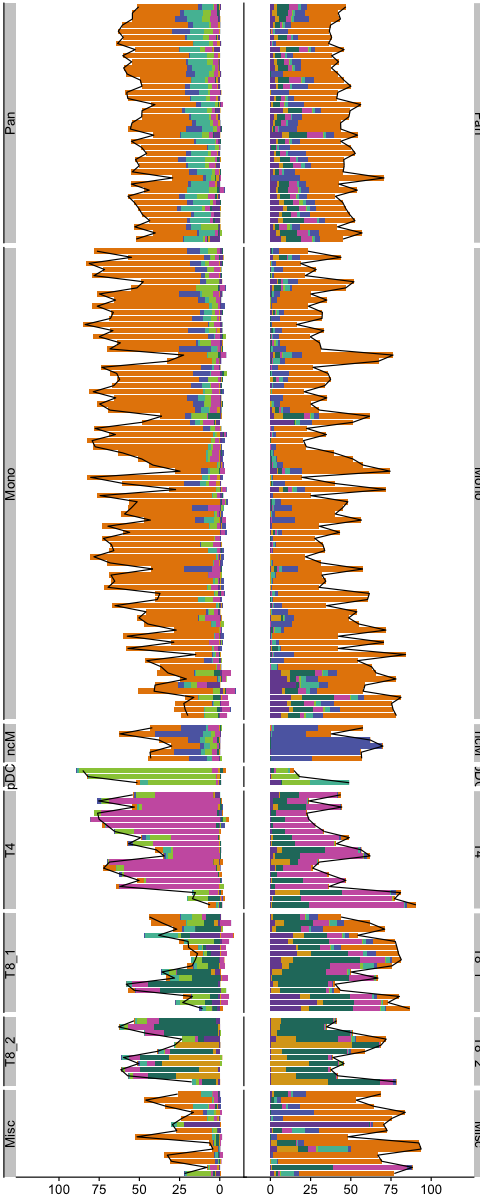

Warning message:
“Removed 1 rows containing missing values (position_stack).”

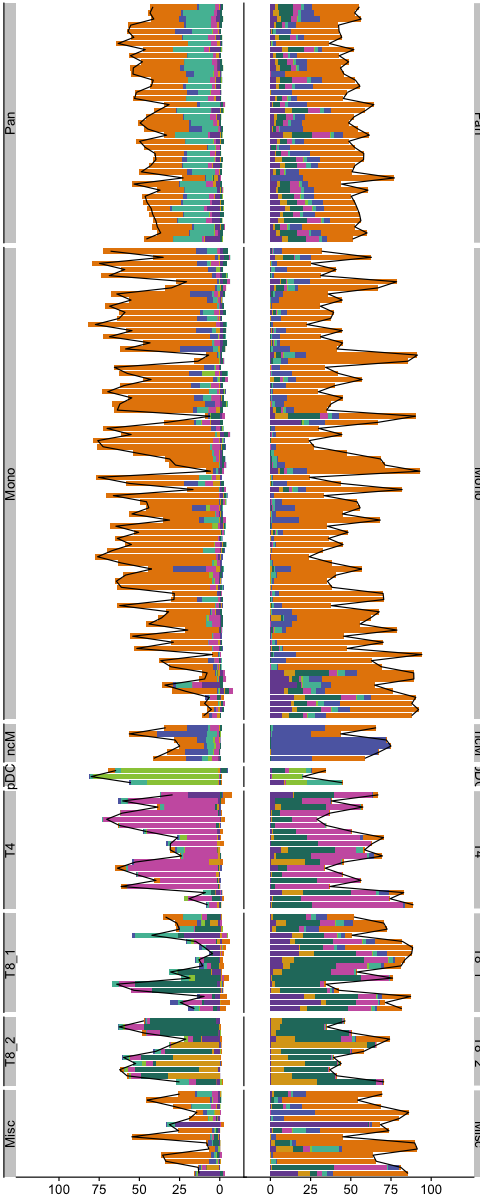

Saving 3 x 7 in image


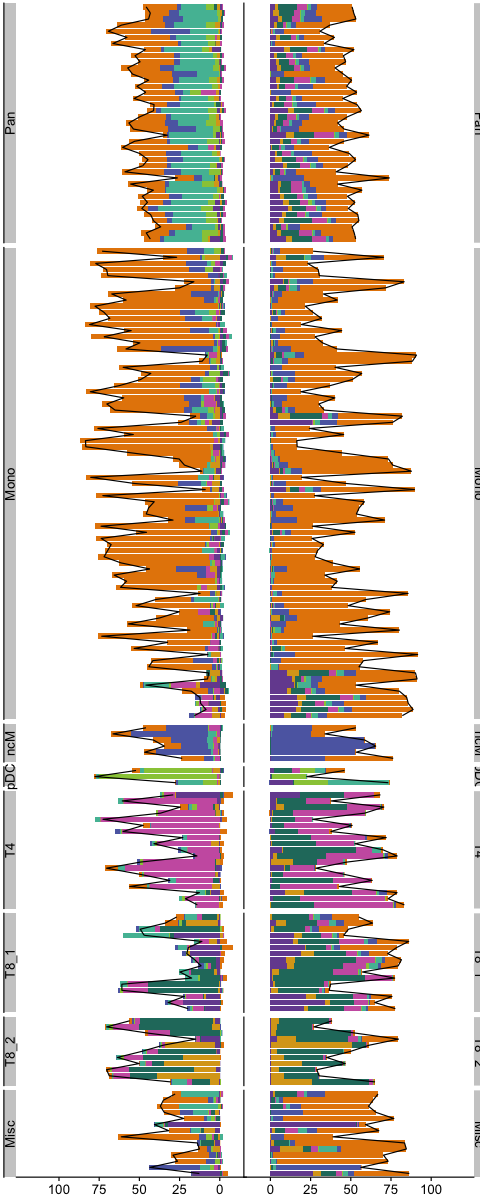

Saving 3 x 7 in image
Warning message:
“Removed 10 rows containing missing values (position_stack).”Warning message:
“Removed 19 rows containing missing values (geom_bar).”

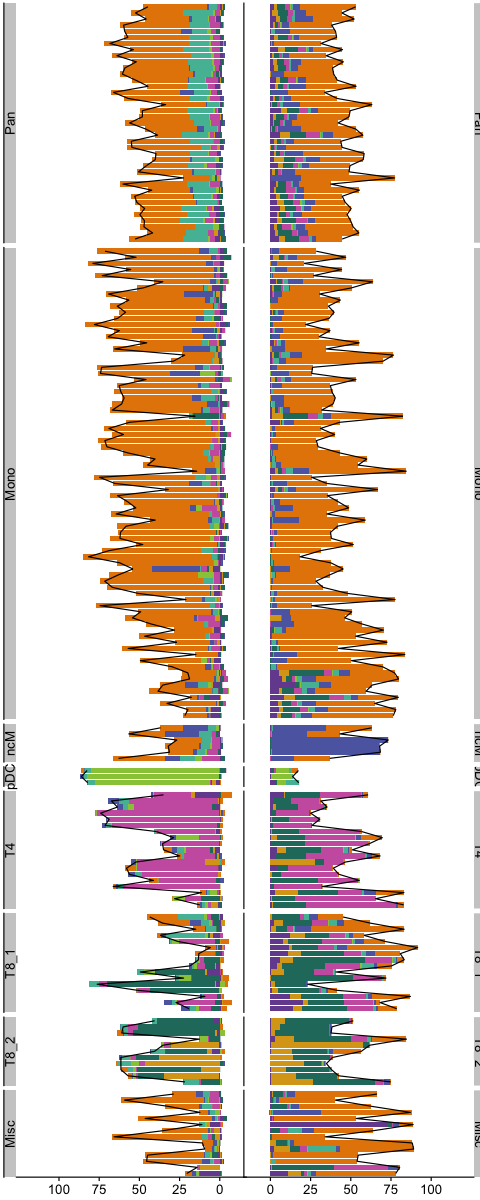

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

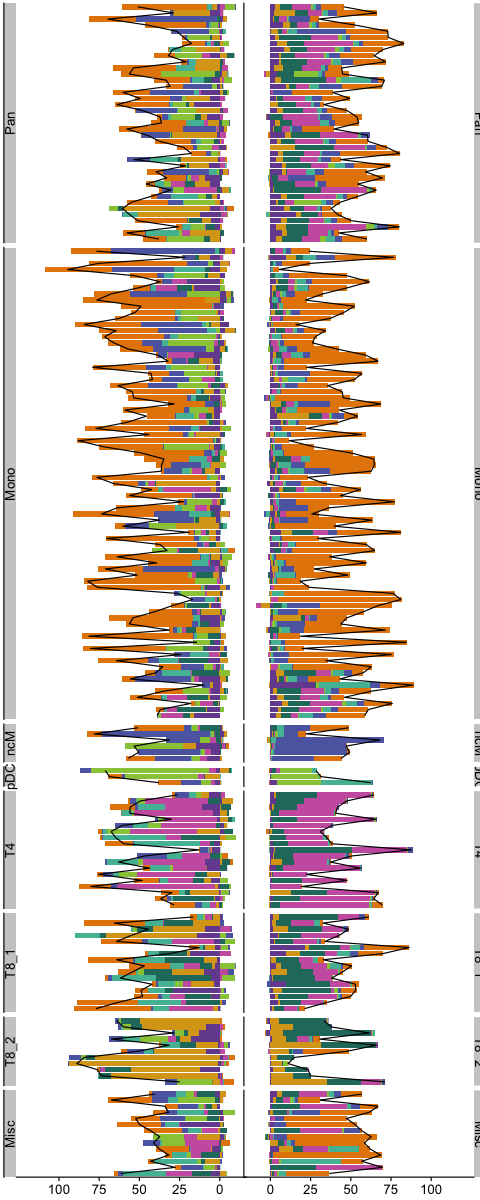

Saving 3 x 7 in image


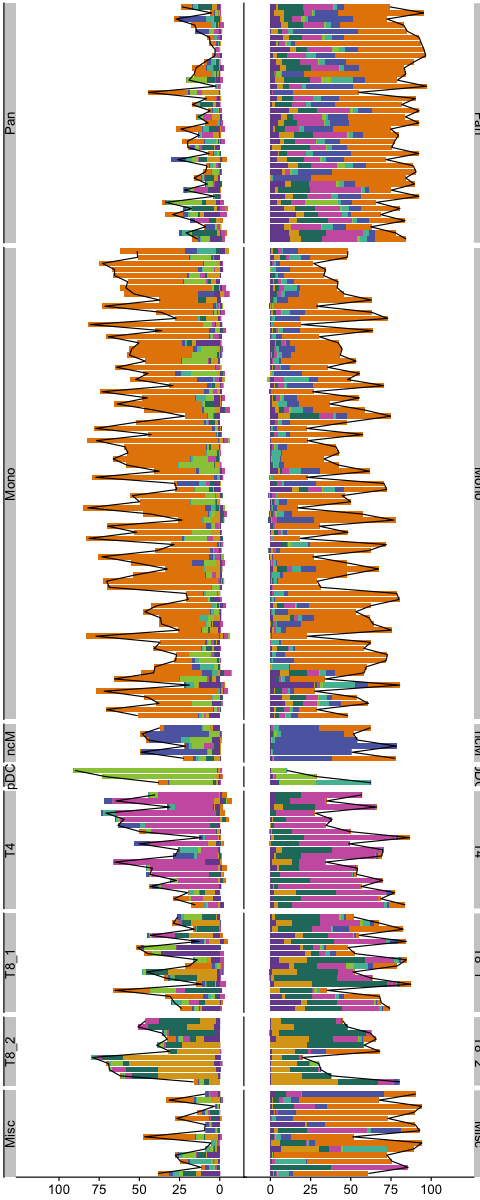

In [91]:
source("helper_functions.R")

a <- plot_bar_chart(output_prop_noint, output_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
b <- plot_bar_chart(output_sle_prop_noint, output_sle_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file="sle_asian_partitioned.png",width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file="sle_white_partitioned.png",width=3);
e <- plot_bar_chart(output_ucsf_healthy_prop_noint, output_ucsf_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file="broad_white_partitioned.png",width=3);


Warning message:
“Removed 1 rows containing missing values (position_stack).”Saving 3 x 7 in image


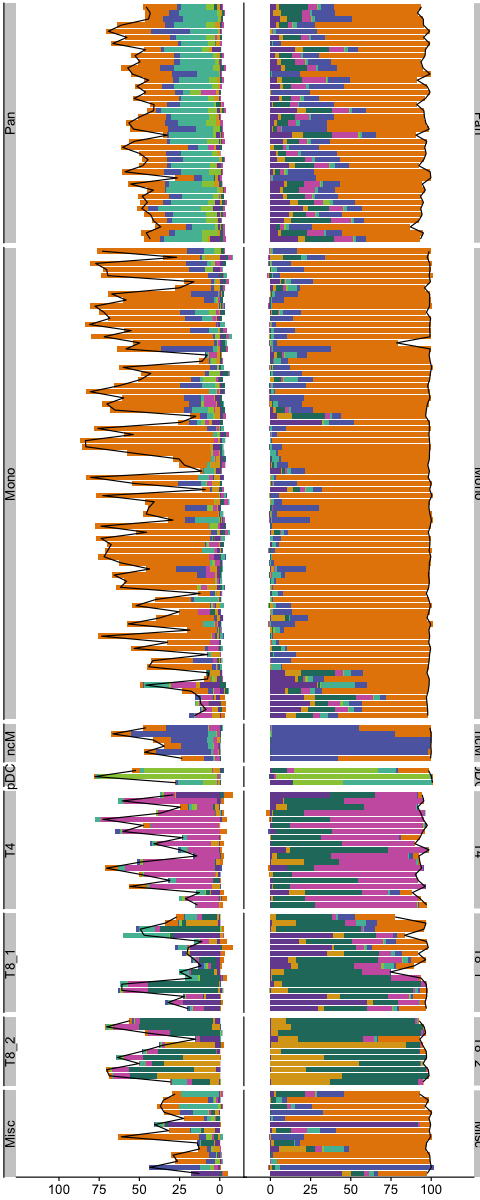

Saving 3 x 7 in image
Warning message:
“Removed 2 rows containing missing values (geom_bar).”

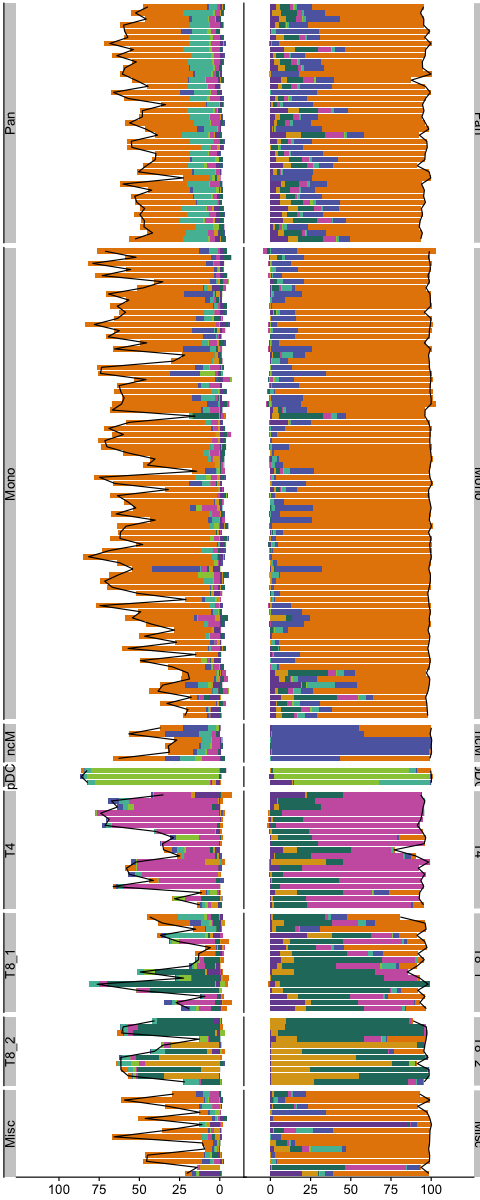

Saving 3 x 7 in image


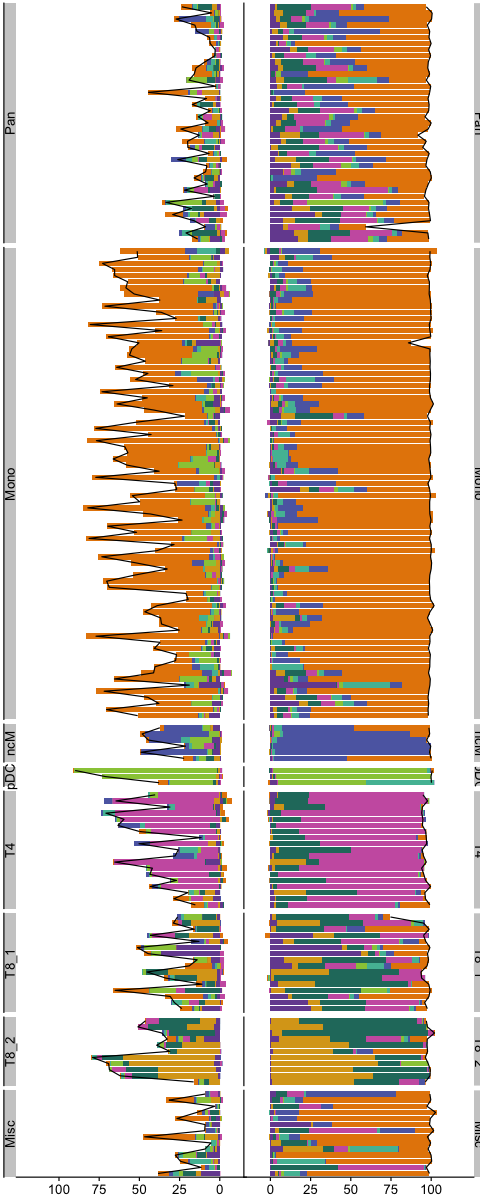

In [92]:
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file="sle_asian_partitioned_pbmc_counts.png",width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file="sle_white_partitioned_pbmc_counts.png",width=3);
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file="broad_white_partitioned_pbmc_counts.png",width=3);


In [93]:
t(output_sle_prop_noint["C1QA",])
t(output_broad_healthy_prop_noint["C1QA",])
t(output_sle_expr_noint["C1QA",])
t(output_broad_healthy_expr_noint["C1QA",])

cM       Th       B           NK           ncM      Tc        cDC     
[1,] 11.18856 3.317756 -0.05112787 -0.009779874 14.19891 0.1975429 2.815532
     pDC       total r2 adj r2   adj prop_expr r2
[1,] 0.8164954 32.47388 27.51784 127.3294

cM        Th         B        NK         ncM     Tc       cDC      
[1,] 0.2880821 0.04066086 3.937867 -0.5839799 41.2435 1.068656 0.4299587
     pDC      total r2 adj r2  adj prop_expr r2
[1,] 2.549099 48.97385 38.2315 103.5323

cM        Th         B          NK         ncM      Tc        cDC      
[1,] 0.6429866 0.02396527 0.05256301 0.01003574 66.17503 0.2456681 0.2574962
     pDC          total r2 adj r2   adj prop_expr r2
[1,] -0.008848516 67.3989  65.00616 92.524

cM        Th         B          NK        ncM      Tc        cDC      
[1,] 0.6065724 0.05340349 0.07491592 -0.173555 48.64364 0.2174398 0.9850285
     pDC       total r2 adj r2  adj prop_expr r2
[1,] 0.3493458 50.75679 40.3898 78.62129

In [94]:
t(output_sle_prop_noint["IL6",])
t(output_broad_healthy_prop_noint["IL6",])
t(output_sle_expr_noint["IL6",])
t(output_broad_healthy_expr_noint["IL6",])

cM        Th         B        NK         ncM       Tc        cDC     
[1,] -1.784967 -0.3022656 27.85069 -0.1631607 0.8390326 0.1789398 4.845153
     pDC       total r2 adj r2  adj prop_expr r2
[1,] -0.117495 31.34593 26.3071 88.49743

cM        Th          B        NK        ncM      Tc        cDC     
[1,] 0.3058602 -0.05585307 5.053857 0.3969122 1.888207 0.1445279 1.170684
     pDC       total r2 adj r2    adj prop_expr r2
[1,] 0.2208974 9.125092 -10.00647 45.05207

cM       Th        B        NK         ncM       Tc        cDC       
[1,] 5.319966 0.8326073 60.58244 0.09060657 0.9745562 0.5016871 0.07842691
     pDC        total r2 adj r2   adj prop_expr r2
[1,] 0.01446138 68.39476 66.07511 92.38221

cM       Th        B        NK       ncM      Tc          cDC        
[1,] 56.27487 0.2880725 21.81902 0.656751 11.00771 -0.01454514 -0.04910046
     pDC        total r2 adj r2   adj prop_expr r2
[1,] 0.02506392 90.00785 87.90424 77.89777

In [95]:
t(output_sle_prop_noint["IFNG",])
t(output_broad_healthy_prop_noint["IFNG",])
t(output_sle_expr_noint["IFNG",])
t(output_broad_healthy_expr_noint["IFNG",])

cM        Th       B        NK         ncM       Tc       cDC      
[1,] 0.2968282 1.737344 2.599442 0.02254744 0.7997354 40.61969 0.9037953
     pDC        total r2 adj r2   adj prop_expr r2
[1,] 0.05725477 47.03664 43.14942 79.60575

cM        Th       B        NK       ncM        Tc       cDC        
[1,] 0.3455602 8.386347 2.229906 9.987492 -0.1034967 25.39617 -0.04242242
     pDC         total r2 adj r2   adj prop_expr r2
[1,] -0.01481232 46.18474 34.85521 71.49618

cM       Th        B         NK       ncM       Tc       cDC      
[1,] 0.692134 0.9049486 0.2021748 7.174273 0.2454649 37.16953 0.2951535
     pDC          total r2 adj r2   adj prop_expr r2
[1,] -0.004300701 46.67938 42.76594 85.91536

cM        Th      B         NK       ncM        Tc       cDC     
[1,] 0.7538361 2.82774 0.5982581 6.268919 0.04748861 34.03931 0.291657
     pDC       total r2 adj r2   adj prop_expr r2
[1,] 0.1911299 45.01834 33.44326 68.29847

In [96]:
t(output_sle_asian_prop_noint["CCR7",])
t(output_sle_white_prop_noint["CCR7",])
t(output_sle_prop_noint["CCR7",])
t(output_broad_healthy_prop_noint["CCR7",])
t(output_prop_noint["CCR7",])

cM        Th       B        NK         ncM        Tc          cDC    
[1,] -1.876232 58.43233 1.580222 -0.2706705 -0.3574743 -0.06577452 2.83889
     pDC       total r2 adj r2   adj prop_expr r2
[1,] 0.3556669 60.63696 54.69537 86.87774

cM       Th      B         NK        ncM      Tc          cDC     
[1,] -2.20532 55.5753 0.4183702 0.3915069 6.842061 -0.03016442 6.244093
     pDC       total r2 adj r2   adj prop_expr r2
[1,] 0.1067611 67.34261 61.78391 84.97682

cM        Th       B         NK         ncM     Tc         cDC     
[1,] -2.509882 55.99229 0.9762849 -0.1927281 2.19294 -0.3333294 4.230619
     pDC        total r2 adj r2   adj prop_expr r2
[1,] 0.01855797 60.37475 57.46647 87.02214

cM        Th      B         NK       ncM      Tc        cDC      
[1,] -3.293711 63.1698 -1.980256 3.813957 4.949083 -1.666412 0.1761948
     pDC       total r2 adj r2   adj prop_expr r2
[1,] -0.611468 64.55719 57.09555 84.94331

cM         Th       B         NK          ncM      Tc        cDC      
[1,] -0.3686299 68.86674 0.1425358 -0.06978291 2.344811 -0.638877 0.3150887
     pDC     total r2 adj r2   adj prop_expr r2
[1,] 4.74293 75.33482 74.22627 91.22769

In [97]:
t(output_sle_asian_prop_noint["CD8B",])
t(output_sle_white_prop_noint["CD8B",])
t(output_broad_healthy_prop_noint["CD8B",])

cM        Th       B         NK       ncM       Tc       cDC      
[1,] -4.008085 7.786779 -2.184011 2.154269 0.3904811 38.02537 0.5044293
     pDC      total r2 adj r2   adj prop_expr r2
[1,] 4.009279 46.67851 38.62998 86.14145

cM        Th       B           NK         ncM       Tc       cDC    
[1,] -2.060158 1.862229 0.004715548 -0.5259415 0.1180063 50.59742 1.90401
     pDC      total r2 adj r2   adj prop_expr r2
[1,] 2.013083 53.91336 46.06883 76.39456

cM        Th       B         NK          ncM      Tc       cDC     
[1,] -0.874464 6.064579 0.8410201 -0.05989396 12.86937 28.94846 1.567138
     pDC       total r2 adj r2   adj prop_expr r2
[1,] 0.3930228 49.74923 39.17012 107.1011

In [98]:
t(output_sle_asian_expr_noint["CD3E",])
t(output_sle_white_expr_noint["CD3E",])
t(output_broad_healthy_expr_noint["CD3E",])

cM        Th       B         NK       ncM        Tc       cDC      
[1,] 0.2126936 4.833495 0.6355983 1.637223 0.07243799 10.43138 0.0290234
     pDC         total r2 adj r2   adj prop_expr r2
[1,] -0.09321428 17.75863 5.344843 83.0708

cM        Th       B          NK       ncM        Tc       cDC      
[1,] 0.2306227 3.590433 0.04508633 1.157104 0.05607473 5.497752 0.1059883
     pDC       total r2 adj r2    adj prop_expr r2
[1,] 0.0619505 10.74501 -4.447327 82.16534

cM       Th       B        NK       ncM      Tc       cDC       pDC      
[1,] 2.885734 16.21011 2.904567 2.304438 1.086782 11.42752 0.5881915 0.4285569
     total r2 adj r2   adj prop_expr r2
[1,] 37.83591 24.74873 77.85141

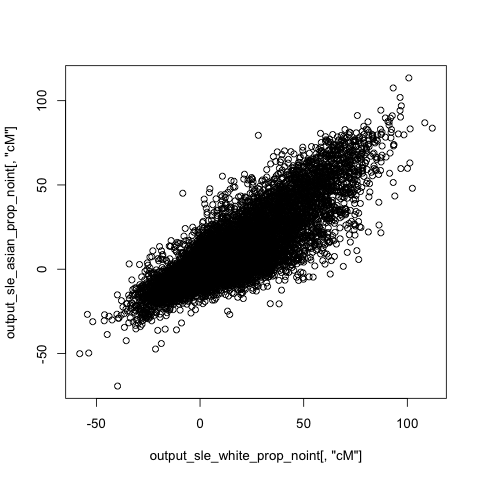

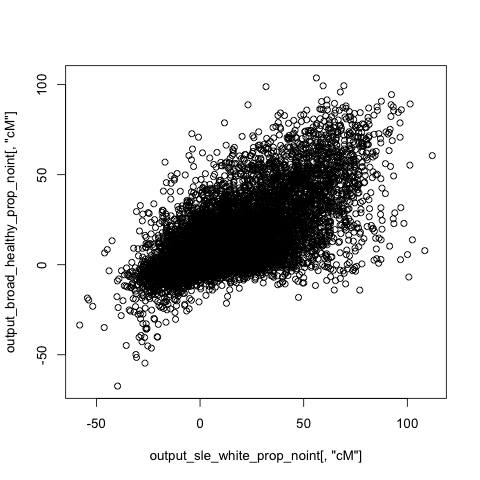

In [99]:
options(repr.plot.width = 6, repr.plot.height = 6);
plot(output_sle_white_prop_noint[,"cM"], output_sle_asian_prop_noint[,"cM"])
plot(output_sle_white_prop_noint[,"cM"], output_broad_healthy_prop_noint[,"cM"])

In [100]:
a <- cbind(rownames(output_sle_white_noint_df)[output_sle_white_noint_df[,"cluster"]=="6"], output_sle_white_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"]-output_broad_healthy_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"])
a[order(as.numeric(a[,2]),decreasing=T),]

[,1] [,2]

# Let's do the estimation using resampling

We are going to work with counts here. Given the expression of an arbitrary gene $i$ and individual $j$ in PBMCs $P$, and two cell types (B and T) for simplicity. $N_j^B$ and $N_j^T$ are the number of B cells and T cells for individual $j$.

\begin{align*}
P_{ij} &= B_{ij1}+B_{ij2}+...+B_{ijN_b}+T_{ij1}+T_{ij2}+...+T_{ijN_t} \\
P_{ij} &= \sum_k^{N_j^B}B_{ijk} + \sum_k^{N_j^T}T_{ijk} \\
P_{ij} &= N_j^B\times{\bar{B}_{ij}} + N_j^T\times{\bar{T}_{ij}} \\
\bar{P_{ij}} &= {{N_j^B}\over{N_j^{PBMC}}}\times{\bar{B_{ij}}} + {{N_j^T}\over{N_j^{PBMC}}}\times{\bar{T_{ij}}} \\
\bar{P_{ij}} &= {{{\rho}_j^B}\times{\bar{B_{ij}}} + {{\rho}_j^T}\times{\bar{T_{ij}}}}
\end{align*}


$\bar{B}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type B. $\bar{T}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type T

First, fit proportion

\begin{align*}
\bar{P_{ij}} &= {{\rho}_j^B}\times{\bar{B_{i}}} + {{\rho}_j^T}\times{\bar{T_{i}}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{B_{i}} = {{\sum_j^{J}\bar{B_{ij}}}\over{J}}$

Second, fit expression

\begin{align*}
\bar{P_{ij}} &= {\bar{{\rho}^B}}\times{B_{ij}} + {\bar{{\rho}^T}}\times{T_{ij}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{{\rho}^B} = {{{\sum_j^{J}{\rho_j^B}}}\over{J}}$


## First, let's do all individuals

In [101]:
# ##joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_expr),joined_pivot$ind_cov),]
# # cm_counts_mean <- sweep(exp(cm_expr), 2, joined_pivot_filtered$counts*cm_prop/100, "/")
# # th_counts_mean <- sweep(exp(th_expr), 2, joined_pivot_filtered$counts*th_prop/100, "/")
# # tc_counts_mean <- sweep(exp(tc_expr), 2, joined_pivot_filtered$counts*tc_prop/100, "/")
# # b_counts_mean <- sweep(exp(b_expr), 2, joined_pivot_filtered$counts*b_prop/100, "/")
# # nk_counts_mean <- sweep(exp(nk_expr), 2, joined_pivot_filtered$counts*nk_prop/100, "/")
# # ncm_counts_mean <- sweep(exp(ncm_expr), 2, joined_pivot_filtered$counts*ncm_prop/100, "/")
# # dc_counts_mean <- sweep(exp(dc_expr), 2, joined_pivot_filtered$counts*dc_prop/100, "/")
# # pbmc_counts_mean <- sweep(exp(pbmc_expr), 2, joined_pivot_filtered$counts, "/")

# cm_counts_mean <- exp(cm_expr)
# th_counts_mean <- exp(th_expr)
# tc_counts_mean <- exp(tc_expr)
# b_counts_mean <- exp(b_expr)
# nk_counts_mean <- exp(nk_expr)
# ncm_counts_mean <- exp(ncm_expr)
# dc_counts_mean <- exp(dc_expr)
# pbmc_counts_mean <- exp(pbmc_expr)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_counts_mean[is.nan(b_counts_mean)] <- 0;
# dc_counts_mean[is.nan(dc_counts_mean)] <- 0;
# b_counts_mean[!is.finite(b_counts_mean)] <- 0;
# dc_counts_mean[!is.finite(dc_counts_mean)] <- 0;

# # cm_counts_global_mean <- rowSums(exp(cm_expr))/sum(joined_pivot_filtered$counts*cm_prop/100, na.rm=T)
# # th_counts_global_mean <- rowSums(exp(th_expr))/sum(joined_pivot_filtered$counts*th_prop/100, na.rm=T)
# # tc_counts_global_mean <- rowSums(exp(tc_expr))/sum(joined_pivot_filtered$counts*tc_prop/100, na.rm=T)
# # b_counts_global_mean <- rowSums(exp(b_expr))/sum(joined_pivot_filtered$counts*b_prop/100, na.rm=T)
# # nk_counts_global_mean <- rowSums(exp(nk_expr))/sum(joined_pivot_filtered$counts*nk_prop/100, na.rm=T)
# # ncm_counts_global_mean <- rowSums(exp(ncm_expr))/sum(joined_pivot_filtered$counts*ncm_prop/100, na.rm=T)
# # dc_counts_global_mean <- rowSums(exp(dc_expr))/sum(joined_pivot_filtered$counts*dc_prop/100, na.rm=T)

# cm_counts_global_mean <- apply(exp(cm_expr),1,mean)
# th_counts_global_mean <- apply(exp(th_expr),1,mean)
# tc_counts_global_mean <- apply(exp(tc_expr),1,mean)
# b_counts_global_mean <- apply(exp(b_expr),1,mean)
# nk_counts_global_mean <- apply(exp(nk_expr),1,mean)
# ncm_counts_global_mean <- apply(exp(ncm_expr),1,mean)
# dc_counts_global_mean <- apply(exp(dc_expr),1,mean)


# a <- cbind(cm_counts_global_mean, th_counts_global_mean, tc_counts_global_mean, b_counts_global_mean, nk_counts_global_mean, ncm_counts_global_mean, dc_counts_global_mean)
# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100, 
#                                b_counts_global_mean[i]*b_prop/100, 
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100, 
#                                tc_counts_global_mean[i]*tc_prop/100,##), na.rm=T)
#                                dc_counts_global_mean[i]*dc_prop/100), na.rm=T)

#     output_direct_global_prop <- rbind(output_direct_global_prop, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }


# rownames(output_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_direct_global_prop) <- c("r2", "res")

# output_direct_global_expr <- NULL;

# cm_prop_global_mean <- sum(joined_pivot_filtered$counts*cm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# th_prop_global_mean <- sum(joined_pivot_filtered$counts*th_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# tc_prop_global_mean <- sum(joined_pivot_filtered$counts*tc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# b_prop_global_mean <- sum(joined_pivot_filtered$counts*b_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# nk_prop_global_mean <- sum(joined_pivot_filtered$counts*nk_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# ncm_prop_global_mean <- sum(joined_pivot_filtered$counts*ncm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# dc_prop_global_mean <- sum(joined_pivot_filtered$counts*dc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)

# a_prop <- c(cm_prop_global_mean, th_prop_global_mean, tc_prop_global_mean, b_prop_global_mean, nk_prop_global_mean, ncm_prop_global_mean, dc_prop_global_mean);

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,##), na.rm=T)
#                               dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)

#     output_direct_global_expr <- rbind(output_direct_global_expr, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }

# rownames(output_direct_global_expr) <- expr_gene_names;
# colnames(output_direct_global_expr) <- c("r2", "res")

In [102]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# ##i=grep("ERAP2",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100,
#                                b_counts_global_mean[i]*b_prop/100,
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100,
#                                tc_counts_global_mean[i]*tc_prop/100,
#                      dc_counts_global_mean[i]*dc_prop/100),na.rm=T)
# plot(log(predicted), log(pbmc_counts_mean[i,]))
# cor(log(predicted), pbmc_expr_std[i,])^2

# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,
#                           dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2


# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop, 
#                               th_counts_mean[i,]*th_prop, 
#                               b_counts_mean[i,]*b_prop,
#                               nk_counts_mean[i,]*nk_prop, 
#                                ncm_counts_mean[i,]*ncm_prop,
#                               tc_counts_mean[i,]*tc_prop,
#                           dc_counts_mean[i,]*dc_prop), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2

## Second, let's do SLE

Mean of means might be a bit unstable, let's calculate a global mean

### All SLE

In [103]:
# # cm_sle_counts_mean <- sweep(exp(cm_sle_expr), 2, joined_pivot_sle$counts*cm_sle_prop/100, "/")
# # th_sle_counts_mean <- sweep(exp(th_sle_expr), 2, joined_pivot_sle$counts*th_sle_prop/100, "/")
# # tc_sle_counts_mean <- sweep(exp(tc_sle_expr), 2, joined_pivot_sle$counts*tc_sle_prop/100, "/")
# # b_sle_counts_mean <- sweep(exp(b_sle_expr), 2, joined_pivot_sle$counts*b_sle_prop/100, "/")
# # nk_sle_counts_mean <- sweep(exp(nk_sle_expr), 2, joined_pivot_sle$counts*nk_sle_prop/100, "/")
# # ncm_sle_counts_mean <- sweep(exp(ncm_sle_expr), 2, joined_pivot_sle$counts*ncm_sle_prop/100, "/")
# # dc_sle_counts_mean <- sweep(exp(dc_sle_expr), 2, joined_pivot_sle$counts*dc_sle_prop/100, "/")
# # pbmc_sle_counts_mean <- sweep(exp(pbmc_sle_expr), 2, joined_pivot_sle$counts, "/")


# cm_sle_counts_mean <- exp(cm_sle_expr);
# th_sle_counts_mean <- exp(th_sle_expr);
# tc_sle_counts_mean <- exp(tc_sle_expr);
# b_sle_counts_mean <- exp(b_sle_expr);
# nk_sle_counts_mean <- exp(nk_sle_expr);
# ncm_sle_counts_mean <- exp(ncm_sle_expr);
# dc_sle_counts_mean <- exp(dc_sle_expr);
# pbmc_sle_counts_mean <- exp(pbmc_sle_expr);

# # cm_sle_counts_global_mean <- rowSums(exp(cm_sle_expr))/sum(joined_pivot_sle$counts*cm_sle_prop/100, na.rm=T)
# # th_sle_counts_global_mean <- rowSums(exp(th_sle_expr))/sum(joined_pivot_sle$counts*th_sle_prop/100, na.rm=T)
# # tc_sle_counts_global_mean <- rowSums(exp(tc_sle_expr))/sum(joined_pivot_sle$counts*tc_sle_prop/100, na.rm=T)
# # b_sle_counts_global_mean <- rowSums(exp(b_sle_expr))/sum(joined_pivot_sle$counts*b_sle_prop/100, na.rm=T)
# # nk_sle_counts_global_mean <- rowSums(exp(nk_sle_expr))/sum(joined_pivot_sle$counts*nk_sle_prop/100, na.rm=T)
# # ncm_sle_counts_global_mean <- rowSums(exp(ncm_sle_expr))/sum(joined_pivot_sle$counts*ncm_sle_prop/100, na.rm=T)
# # dc_sle_counts_global_mean <- rowSums(exp(dc_sle_expr))/sum(joined_pivot_sle$counts*dc_sle_prop/100, na.rm=T)

# cm_sle_counts_global_mean <- apply(exp(cm_sle_expr),1,mean)
# th_sle_counts_global_mean <- apply(exp(th_sle_expr),1,mean)
# tc_sle_counts_global_mean <- apply(exp(tc_sle_expr),1,mean)
# b_sle_counts_global_mean <- apply(exp(b_sle_expr),1,mean)
# nk_sle_counts_global_mean <- apply(exp(nk_sle_expr),1,mean)
# ncm_sle_counts_global_mean <- apply(exp(ncm_sle_expr),1,mean)
# dc_sle_counts_global_mean <- apply(exp(dc_sle_expr),1,mean)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_sle_counts_mean[is.nan(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[is.nan(dc_sle_counts_mean)] <- 0;
# b_sle_counts_mean[!is.finite(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[!is.finite(dc_sle_counts_mean)] <- 0;

# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_sle_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop/100),na.rm=T)

#     output_sle_direct_global_prop <- rbind(output_sle_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }


# rownames(output_sle_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_direct_global_prop) <- c("r2", "res")

# output_sle_direct_global_expr <- NULL;

# cm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*cm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# th_sle_prop_global_mean <- sum(joined_pivot_sle$counts*th_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# tc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*tc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# b_sle_prop_global_mean <- sum(joined_pivot_sle$counts*b_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# nk_sle_prop_global_mean <- sum(joined_pivot_sle$counts*nk_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# ncm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*ncm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# dc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*dc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean,
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean,
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i]*dc_sle_prop_global_mean),na.rm=T)

#    ##output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, c(var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100))
#   output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }

# rownames(output_sle_direct_global_expr) <- expr_gene_names;
# colnames(output_sle_direct_global_expr) <- c("r2", "res")

In [104]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=2
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,
#                           dc_sle_counts_global_mean[i]*dc_sle_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2
# output_sle_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean, 
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean, 
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                           dc_sle_counts_mean[i,]*dc_sle_prop_global_mean), na.rm=T)

# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop, 
#                               th_sle_counts_mean[i,]*th_sle_prop, 
#                               b_sle_counts_mean[i,]*b_sle_prop,
#                               nk_sle_counts_mean[i,]*nk_sle_prop, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop,
#                               tc_sle_counts_mean[i,]*tc_sle_prop,
#                           dc_sle_counts_mean[i,]*dc_sle_prop), na.rm=T)
# plot(predicted, pbmc_sle_counts_mean[i,])
# cor(predicted, pbmc_sle_counts_mean[i,])^2



### Now, let's downsample to 46 and redo SLE

In [105]:
# cm_sle_down_counts_global_mean <- apply(exp(cm_sle_expr[,samples]),1,mean)
# th_sle_down_counts_global_mean <- apply(exp(th_sle_expr[,samples]),1,mean)
# tc_sle_down_counts_global_mean <- apply(exp(tc_sle_expr[,samples]),1,mean)
# b_sle_down_counts_global_mean <- apply(exp(b_sle_expr[,samples]),1,mean)
# nk_sle_down_counts_global_mean <- apply(exp(nk_sle_expr[,samples]),1,mean)
# ncm_sle_down_counts_global_mean <- apply(exp(ncm_sle_expr[,samples]),1,mean)
# dc_sle_down_counts_global_mean <- apply(exp(dc_sle_expr[,samples]),1,mean)

# # cm_sle_down_counts_global_mean <- rowSums(exp(cm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples])
# # th_sle_down_counts_global_mean <- rowSums(exp(th_sle_expr[,samples]))/sum((joined_pivot_sle$counts*th_sle_prop/100)[samples])
# # tc_sle_down_counts_global_mean <- rowSums(exp(tc_sle_expr[,samples]))/sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples])
# # b_sle_down_counts_global_mean <- rowSums(exp(b_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)
# # nk_sle_down_counts_global_mean <- rowSums(exp(nk_sle_expr[,samples]))/sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples])
# # ncm_sle_down_counts_global_mean <- rowSums(exp(ncm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples])
# # dc_sle_down_counts_global_mean <- rowSums(exp(dc_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)

# output_sle_down_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),samples])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop[samples]/100, 
#                                th_sle_counts_global_mean[i]*th_sle_prop[samples]/100, 
#                                b_sle_counts_global_mean[i]*b_sle_prop[samples]/100, 
#                                nk_sle_counts_global_mean[i]*nk_sle_prop[samples]/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop[samples]/100, 
#                                tc_sle_counts_global_mean[i]*tc_sle_prop[samples]/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop[samples]/100), na.rm=T)

#     output_sle_down_direct_global_prop <- rbind(output_sle_down_direct_global_prop,
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
# }


# rownames(output_sle_down_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_down_direct_global_prop) <- c("r2", "res")

# output_sle_down_direct_global_expr <- NULL;

# cm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# th_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*th_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# tc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# b_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)
# nk_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# ncm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# dc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,samples]*cm_sle_down_prop_global_mean,
#                               th_sle_counts_mean[i,samples]*th_sle_down_prop_global_mean, 
#                               b_sle_counts_mean[i,samples]*b_sle_down_prop_global_mean, 
#                               nk_sle_counts_mean[i,samples]*nk_sle_down_prop_global_mean,
#                               ncm_sle_counts_mean[i,samples]*ncm_sle_down_prop_global_mean, 
#                               tc_sle_counts_mean[i,samples]*tc_sle_down_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i,samples]*dc_sle_down_prop_global_mean), na.rm=T)

#     output_sle_down_direct_global_expr <- rbind(output_sle_down_direct_global_expr, 
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
  
# }


## Finally, processed the healthy

In [106]:
# cm_healthy_counts_mean <- exp(cm_healthy_expr)
# th_healthy_counts_mean <- exp(th_healthy_expr)
# tc_healthy_counts_mean <- exp(tc_healthy_expr)
# b_healthy_counts_mean <- exp(b_healthy_expr)
# nk_healthy_counts_mean <- exp(nk_healthy_expr)
# ncm_healthy_counts_mean <- exp(ncm_healthy_expr)
# dc_healthy_counts_mean <- exp(dc_healthy_expr)
# pbmc_healthy_counts_mean <- exp(pbmc_healthy_expr)


# # cm_healthy_counts_mean <- sweep(exp(cm_healthy_expr), 2, joined_pivot_healthy$counts*cm_healthy_prop/100, "/")
# # th_healthy_counts_mean <- sweep(exp(th_healthy_expr), 2, joined_pivot_healthy$counts*th_healthy_prop/100, "/")
# # tc_healthy_counts_mean <- sweep(exp(tc_healthy_expr), 2, joined_pivot_healthy$counts*tc_healthy_prop/100, "/")
# # b_healthy_counts_mean <- sweep(exp(b_healthy_expr), 2, joined_pivot_healthy$counts*b_healthy_prop/100, "/")
# # nk_healthy_counts_mean <- sweep(exp(nk_healthy_expr), 2, joined_pivot_healthy$counts*nk_healthy_prop/100, "/")
# # ncm_healthy_counts_mean <- sweep(exp(ncm_healthy_expr), 2, joined_pivot_healthy$counts*ncm_healthy_prop/100, "/")
# # dc_healthy_counts_mean <- sweep(exp(dc_healthy_expr), 2, joined_pivot_healthy$counts*dc_healthy_prop/100, "/")
# # pbmc_healthy_counts_mean <- sweep(exp(pbmc_healthy_expr), 2, joined_pivot_healthy$counts, "/")

# cm_healthy_counts_global_mean <- apply(exp(cm_healthy_expr),1,mean)
# th_healthy_counts_global_mean <- apply(exp(th_healthy_expr),1,mean)
# tc_healthy_counts_global_mean <- apply(exp(tc_healthy_expr),1,mean)
# b_healthy_counts_global_mean <- apply(exp(b_healthy_expr),1,mean)
# nk_healthy_counts_global_mean <- apply(exp(nk_healthy_expr),1,mean)
# ncm_healthy_counts_global_mean <- apply(exp(ncm_healthy_expr),1,mean)
# dc_healthy_counts_global_mean <- apply(exp(dc_healthy_expr),1,mean)

# # cm_healthy_counts_global_mean <- rowSums(exp(cm_healthy_expr))/sum(joined_pivot_healthy$counts*cm_healthy_prop/100, na.rm=T)
# # th_healthy_counts_global_mean <- rowSums(exp(th_healthy_expr))/sum(joined_pivot_healthy$counts*th_healthy_prop/100, na.rm=T)
# # tc_healthy_counts_global_mean <- rowSums(exp(tc_healthy_expr))/sum(joined_pivot_healthy$counts*tc_healthy_prop/100, na.rm=T)
# # b_healthy_counts_global_mean <- rowSums(exp(b_healthy_expr))/sum(joined_pivot_healthy$counts*b_healthy_prop/100, na.rm=T)
# # nk_healthy_counts_global_mean <- rowSums(exp(nk_healthy_expr))/sum(joined_pivot_healthy$counts*nk_healthy_prop/100, na.rm=T)
# # ncm_healthy_counts_global_mean <- rowSums(exp(ncm_healthy_expr))/sum(joined_pivot_healthy$counts*ncm_healthy_prop/100, na.rm=T)
# # dc_healthy_counts_global_mean <- rowSums(exp(dc_healthy_expr))/sum(joined_pivot_healthy$counts*dc_healthy_prop/100, na.rm=T)

# ##healthy_counts_means <- cbind(cm_healthy_counts_mean, th_healthy_counts_mean, tc_healthy_counts_mean, b_healthy_counts_mean, nk_healthy_counts_mean, ncm_healthy_counts_mean, dc_healthy_counts_mean)

# output_healthy_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,##), na.rm=T)
#                                dc_healthy_counts_global_mean[i]*dc_healthy_prop/100),na.rm=T)

#     output_healthy_direct_global_prop <- rbind(output_healthy_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }


# rownames(output_healthy_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_healthy_direct_global_prop) <- c("r2", "res")

# output_healthy_direct_global_expr <- NULL;

# cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean,
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean,
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,##), na.rm=T)
#                               dc_healthy_counts_mean[i]*dc_healthy_prop_global_mean),na.rm=T)

#    ##output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, c(var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100))
#   output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }

# rownames(output_healthy_direct_global_expr) <- expr_gene_names;
# colnames(output_healthy_direct_global_expr) <- c("r2", "res")

In [107]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,
#                           dc_healthy_counts_global_mean[i]*dc_healthy_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2*100
# output_healthy_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2


# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop), na.rm=T)
# plot(predicted, pbmc_healthy_counts_mean[i,])
# cor(predicted, pbmc_healthy_counts_mean[i,])^2

## Plotting

In [108]:
# df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
#       prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
#       expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
#       sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
# rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

# df2

# df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
#              data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

# rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

# df3


# output_direct_global_df <- data.frame(prop=output_direct_global_prop[,1], expr=output_direct_global_expr[,1], type="all_direct")
# output_direct_global_df$cluster <- "no_diff";
# output_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_direct_global_df <- data.frame(prop=output_sle_direct_global_prop[,1], expr=output_sle_direct_global_expr[,1], type="sle_direct")
# output_sle_direct_global_df$cluster <- "no_diff";
# output_sle_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_down_direct_global_df <- data.frame(prop=output_sle_down_direct_global_prop[,1], expr=output_sle_down_direct_global_expr[,1], type="sle_down_direct")
# output_sle_down_direct_global_df$cluster <- "no_diff";
# output_sle_down_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_down_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_healthy_direct_global_df <- data.frame(prop=output_healthy_direct_global_prop[,1], expr=output_healthy_direct_global_expr[,1], type="healthy_direct")
# output_healthy_direct_global_df$cluster <- "no_diff";
# output_healthy_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_healthy_direct_global_df)))] <- cuttree_out[,"cluster"];

# df <- rbind(output_direct_global_df, output_sle_direct_global_df, output_sle_down_direct_global_df, output_healthy_direct_global_df)
# df$cluster <- as.factor(df$cluster)


# options(repr.plot.width = 10, repr.plot.height = 3)
# df_all_ifn <- df;
# df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
# df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
# df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
# df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
# ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)


# options(repr.plot.width = 9, repr.plot.height = 3)
# ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
#              aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

# df2 <- data.frame(cor=c(cor(output_direct_global_prop[,1], output_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_direct_global_prop[,1], output_sle_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_down_direct_global_prop[,1], output_sle_down_direct_global_expr[,1],use='complete.obs'),
#                         cor(output_healthy_direct_global_prop[,1], output_healthy_direct_global_expr[,1])),
#       prop_mean=c(mean(output_direct_global_prop[,1],na.rm=T), mean(output_sle_direct_global_prop[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1])),
#       expr_mean=c(mean(output_direct_global_expr[,1]), mean(output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_expr[,1])),
#       sum_mean = c(mean(output_direct_global_prop[,1]+output_direct_global_expr[,1],na.rm=T), mean(output_sle_direct_global_prop[,1]+output_sle_direct_global_expr[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1]+output_sle_down_direct_global_expr[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1]+output_healthy_direct_global_expr[,1])))
# rownames(df2) <- c("all_direct", "sle_direct", "sle_down_direct", "healthy_direct")

# df2


## Compare to previous estimates using linear regression

In [109]:
# df <- rbind(data.frame(direct=output_direct_global_prop[,1], regression=output_prop_noint[,"adj r2"], type="all prop"),
#             data.frame(direct=output_direct_global_expr[,1], regression=output_expr_noint[,"adj r2"], type="all expr"),
            
#             data.frame(direct=output_sle_direct_global_prop[,1], regression=output_sle_prop_noint[,"adj r2"], type="sle prop"),
#             data.frame(direct=output_sle_direct_global_expr[,1], regression=output_sle_expr_noint[,"adj r2"], type="sle expr"),
            
#             data.frame(direct=output_sle_down_direct_global_prop[,1], regression=output_sle_down_prop_noint[,"adj r2"], type="sle down prop"),
#             data.frame(direct=output_sle_down_direct_global_expr[,1], regression=output_sle_down_expr_noint[,"adj r2"], type="sle down expr"),
            
#             data.frame(direct=output_healthy_direct_global_prop[,1], regression=output_healthy_prop_noint[,"adj r2"], type="healthy prop"),
#             data.frame(direct=output_healthy_direct_global_expr[,1], regression=output_healthy_expr_noint[,"adj r2"], type="healthy expr"))
  
# options(repr.plot.width = 8, repr.plot.height = 5)
# ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+xlim(0,100)+ylim(0,100)+geom_abline(slope=1, intercept=0,
#   na.rm = FALSE, show.legend = NA)
# ##ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+geom_abline(slope=1, intercept=0,
# ##  na.rm = FALSE, show.legend = NA)


In [110]:
# cor(output_sle_direct_global_prop[,1], output_sle_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_direct_global_expr[,1], output_sle_expr_noint[,"adj r2"])

# cor(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])

# cor(output_healthy_direct_global_prop[,1], output_healthy_prop_noint[,"adj r2"])
# cor(output_healthy_direct_global_expr[,1], output_healthy_expr_noint[,"adj r2"])

In [111]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])


In [112]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_healthy_direct_global_prop[,1])
# plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_healthy_direct_global_expr[,1])
# plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])